In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd

# Rutas
ruta_color = "/content/drive/MyDrive/Colab Notebooks/Espectral/COLOR.xlsx"
ruta_conc = "/content/drive/MyDrive/TESIS_ZANAHORIA/Espectral/concentraciones_carotenoides_2401.csv"

# Cargar datasets
color_data = pd.read_excel(ruta_color)
conc_data = pd.read_csv(ruta_conc)

print("COLOR DATA:")
display(color_data.head())

print("CONCENTRACIONES:")
display(conc_data.head())


COLOR DATA:


,Dia_muestreo,Material,Repeticion,L,a,b
0,2024-10-09,Morada,1,26.93,2.82,4.83
1,2024-10-09,Morada,2,30.60,3.74,3.88
2,2024-10-09,Morada,3,30.90,4.51,6.59
3,2024-10-09,Amarilla,1,59.33,2.02,39.34
4,2024-10-09,Amarilla,2,59.31,1.65,42.08


CONCENTRACIONES:


,Material,Tipo_Concentracion,Concentracion,Dia_muestreo
0,MORADA,Concentracion_Carotenoides,7.246508,9/10/2024
1,MORADA,Concentracion_Carotenoides,7.784998,9/10/2024
2,MORADA,Concentracion_Carotenoides,6.696845,9/10/2024
3,MORADA,Concentracion_Carotenoides,7.165392,9/10/2024
4,MORADA,Concentracion_Carotenoides,7.584155,9/10/2024


In [7]:
print(color_data.columns)
print(conc_data.columns)


Index(['Dia_muestreo', 'Material', 'Repeticion', 'L', 'a', 'b'], dtype='object')
Index(['Material', 'Tipo_Concentracion', 'Concentracion', 'Dia_muestreo'], dtype='object')


In [11]:
# Convertir Dia_muestreo a texto en ambos dataframes
color_data['Dia_muestreo'] = color_data['Dia_muestreo'].astype(str).str.strip()
conc_data['Dia_muestreo'] = conc_data['Dia_muestreo'].astype(str).str.strip()


In [16]:
import pandas as pd

# --- NORMALIZAR MATERIAL ---

# Pasar todo a minúsculas (evita AMARILLO vs Amarilla)
color_data['Material'] = color_data['Material'].str.lower().str.strip()
conc_data['Material'] = conc_data['Material'].str.lower().str.strip()

# Corregir: amarilla -> amarillo  (según tu CSV es AMARILLO)
color_data['Material'] = color_data['Material'].replace({
    'amarilla': 'amarillo'
})

print("Material COLOR:", color_data['Material'].unique())
print("Material CONC:", conc_data['Material'].unique())

# --- NORMALIZAR DIAS ---

# COLOR viene en formato YYYY-MM-DD → convertir a datetime y luego a string uniforme
color_data['Dia_muestreo'] = pd.to_datetime(color_data['Dia_muestreo']).dt.strftime('%Y-%m-%d')

# CONC viene en formato DD/MM/YYYY, pero tiene errores "9/11/2024" etc.
# Primero corregimos los días malos: todos los que empiezan con "9/" deben ser 09/10/2024
conc_data['Dia_muestreo'] = conc_data['Dia_muestreo'].astype(str)

conc_data['Dia_muestreo'] = conc_data['Dia_muestreo'].replace({
    d: '9/10/2024' for d in conc_data['Dia_muestreo'].unique() if d.startswith('9/')
})

# Ahora convertir CONC a datetime estándar
conc_data['Dia_muestreo'] = pd.to_datetime(conc_data['Dia_muestreo'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

print("Dias COLOR:", color_data['Dia_muestreo'].unique())
print("Dias CONC:", conc_data['Dia_muestreo'].unique())


Material COLOR: ['morada' 'amarillo' '6kur' '14ber' 'blanca']
Material CONC: ['morada' 'amarillo' 'blanca' '6kur' '14ber']
Dias COLOR: ['2024-10-09' '2024-10-16' '2024-10-23' '2024-10-30']
Dias CONC: ['2024-10-09' '2024-10-16' '2024-10-23' '2024-10-30']


In [17]:
df_modelo = pd.merge(
    color_data[['Material', 'Dia_muestreo', 'L', 'a', 'b']],
    conc_data[['Material', 'Dia_muestreo', 'Concentracion']],
    on=['Material', 'Dia_muestreo'],
    how='inner'
)

print("Dataset final para el modelo:")
display(df_modelo.head())
print("Tamaño:", df_modelo.shape)


Dataset final para el modelo:


,Material,Dia_muestreo,L,a,b,Concentracion
0,morada,2024-10-09,26.93,2.82,4.83,7.246508
1,morada,2024-10-09,26.93,2.82,4.83,7.784998
2,morada,2024-10-09,26.93,2.82,4.83,6.696845
3,morada,2024-10-09,26.93,2.82,4.83,7.165392
4,morada,2024-10-09,26.93,2.82,4.83,7.584155


Tamaño: (14400, 6)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Variables
X = df_modelo[['L', 'a', 'b']]
y = df_modelo['Concentracion']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Modelo Random Forest
rf_model = RandomForestRegressor(
    n_estimators=700,
    max_depth=None,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² del modelo: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")


R² del modelo: 0.988
RMSE: 2.899


In [25]:
import numpy as np

# df_modelo ya tiene: Material, Dia_muestreo, L, a, b, Concentracion

# C* = croma
df_modelo['C'] = np.sqrt(df_modelo['a']**2 + df_modelo['b']**2)

# Máximos en toda la población
b_max = df_modelo['b'].max()
a_max = df_modelo['a'].max()
C_max = df_modelo['C'].max()

print("b_max:", b_max, "a_max:", a_max, "C_max:", C_max)

# Índice ICcarot
df_modelo['ICcarot'] = (
    0.7 * (df_modelo['b'] / b_max) +
    0.2 * (df_modelo['a'] / a_max) +
    0.1 * (df_modelo['C'] / C_max)
)


b_max: 43.56 a_max: 25.48 C_max: 47.69625561823486


In [26]:
q1, q2 = df_modelo['ICcarot'].quantile([0.33, 0.66])
umbral_ic_bajo  = q1
umbral_ic_medio = q2

print("Umbral Bajo/Medio (ICcarot):", umbral_ic_bajo)
print("Umbral Medio/Alto (ICcarot):", umbral_ic_medio)


Umbral Bajo/Medio (ICcarot): 0.3931251518762081
Umbral Medio/Alto (ICcarot): 0.7665917040124056


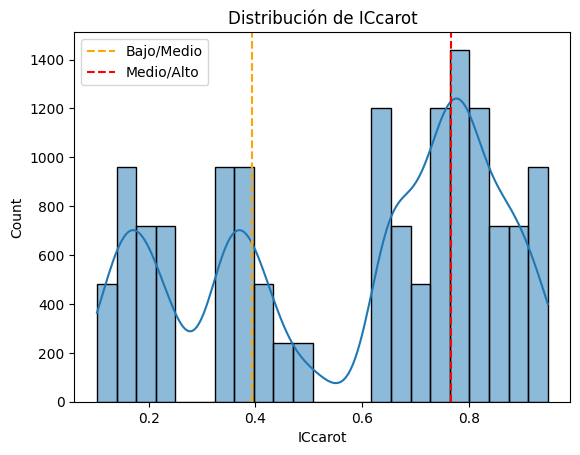

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_modelo['ICcarot'], kde=True)
plt.axvline(umbral_ic_bajo,  color='orange', linestyle='--', label='Bajo/Medio')
plt.axvline(umbral_ic_medio, color='red',    linestyle='--', label='Medio/Alto')
plt.legend()
plt.title("Distribución de ICcarot")
plt.show()


In [28]:
def predecir_carotenoides(valores_color):
    L, a, b = valores_color['L'], valores_color['a'], valores_color['b']

    # 1. Predicción de ppm con el modelo Random Forest
    X_new = np.array([[L, a, b]])
    ppm = rf_model.predict(X_new)[0]

    # 2. Calcular C* e ICcarot para esa imagen
    C = np.sqrt(a**2 + b**2)
    ICcarot = (
        0.7 * (b / b_max) +
        0.2 * (a / a_max) +
        0.1 * (C / C_max)
    )

    # 3. Clasificación según ICcarot
    if ICcarot <= umbral_ic_bajo:
        categoria = "Bajo"
    elif ICcarot <= umbral_ic_medio:
        categoria = "Medio"
    else:
        categoria = "Alto"

    return {
        'valores_lab': {
            'L': round(L,1),
            'a': round(a,1),
            'b': round(b,1)
        },
        'ppm': round(float(ppm), 2),
        'ICcarot': round(float(ICcarot), 3),
        'categoria': categoria
    }


Sube una imagen de zanahoria (JPG/PNG):


Saving Carrots-air-cracks.jpg to Carrots-air-cracks.jpg

=== RESULTADO DEL MODELO ===
L* = 77.5
a* = 16.8
b* = 15.8
ICcarot = 0.434
Carotenoides estimados = 77.56 ppm
Categoría = Medio


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


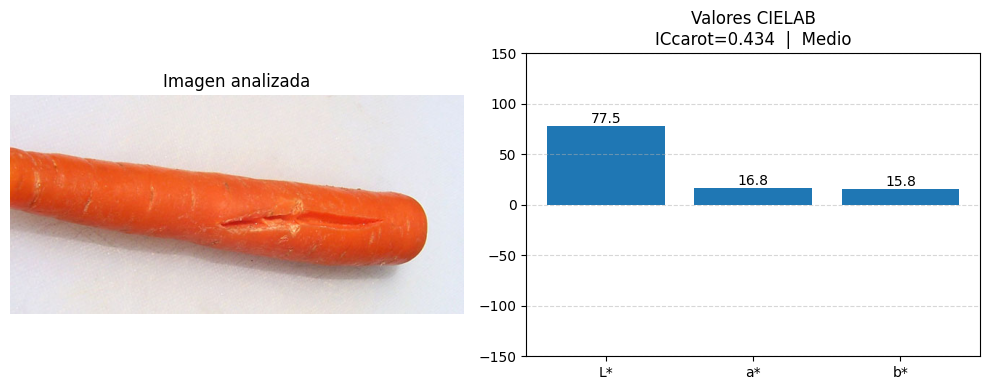

In [29]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# -------- 1. Procesar imagen: obtener L*, a*, b* promedio --------
def procesar_imagen(ruta_imagen):
    """
    Extrae valores promedio L*, a*, b* de una imagen en espacio CIELAB.
    """
    try:
        img = cv2.imread(ruta_imagen)
        if img is None:
            raise ValueError("No se pudo leer la imagen")

        # Redimensionar si es muy grande
        if max(img.shape) > 1000:
            img = cv2.resize(img, (500, 500))

        # BGR -> LAB
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Promedios
        L = np.mean(img_lab[:, :, 0]) * 100 / 255
        a = np.mean(img_lab[:, :, 1]) - 128
        b = np.mean(img_lab[:, :, 2]) - 128

        return {'L': L, 'a': a, 'b': b}
    except Exception as e:
        print(f"Error procesando imagen: {str(e)}")
        return None


# -------- 2. Predicción: ppm + ICcarot + categoría --------
def predecir_carotenoides(valores_color):
    """
    Usa el modelo rf_model para predecir carotenoides (ppm) y
    el índice ICcarot para clasificar en Bajo/Medio/Alto.
    Requiere que rf_model, b_max, a_max, C_max, umbral_ic_bajo, umbral_ic_medio
    estén definidos en el entorno.
    """
    try:
        L, a, b = valores_color['L'], valores_color['a'], valores_color['b']

        # 1) Predicción de ppm con Random Forest
        X_new = np.array([[L, a, b]])
        ppm = rf_model.predict(X_new)[0]

        # 2) Calcular C* e ICcarot
        C = np.sqrt(a**2 + b**2)
        ICcarot = (
            0.7 * (b / b_max) +
            0.2 * (a / a_max) +
            0.1 * (C / C_max)
        )

        # 3) Clasificación según ICcarot
        if ICcarot <= umbral_ic_bajo:
            categoria = "Bajo"
        elif ICcarot <= umbral_ic_medio:
            categoria = "Medio"
        else:
            categoria = "Alto"

        return {
            'valores_lab': {
                'L': round(L, 1),
                'a': round(a, 1),
                'b': round(b, 1)
            },
            'ppm': round(float(ppm), 2),
            'ICcarot': round(float(ICcarot), 3),
            'categoria': categoria
        }

    except Exception as e:
        print(f"Error en predicción: {str(e)}")
        return None


# -------- 3. Función para subir imagen y ver resultados --------
def ejecutar_prediccion_desde_imagen():
    print("Sube una imagen de zanahoria (JPG/PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("No se subió ninguna imagen.")
        return

    # Tomar el primer archivo subido
    ruta = next(iter(uploaded))

    # 1) Extraer L*, a*, b*
    valores = procesar_imagen(ruta)
    if not valores:
        return

    # 2) Predecir carotenoides e índice
    resultado = predecir_carotenoides(valores)
    if not resultado:
        return

    # 3) Mostrar resultados numéricos
    print("\n=== RESULTADO DEL MODELO ===")
    print(f"L* = {resultado['valores_lab']['L']}")
    print(f"a* = {resultado['valores_lab']['a']}")
    print(f"b* = {resultado['valores_lab']['b']}")
    print(f"ICcarot = {resultado['ICcarot']}")
    print(f"Carotenoides estimados = {resultado['ppm']} ppm")
    print(f"Categoría = {resultado['categoria']}")

    # 4) Visualización gráfica
    plt.figure(figsize=(10, 4))

    # Imagen original
    plt.subplot(1, 2, 1)
    img = cv2.imread(ruta)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("Imagen analizada")
    plt.axis('off')

    # Barras LAB
    plt.subplot(1, 2, 2)
    vals = resultado['valores_lab']
    barras = plt.bar(['L*', 'a*', 'b*'], [vals['L'], vals['a'], vals['b']])

    for bar in barras:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h,
                 f'{h:.1f}', ha='center', va='bottom')

    plt.title(f"Valores CIELAB\nICcarot={resultado['ICcarot']}  |  {resultado['categoria']}")
    plt.ylim(-150, 150)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# Llamar a la función para probar
ejecutar_prediccion_desde_imagen()


Sube una imagen de zanahoria (JPG/PNG):


Saving Copia de 20240229_102118.jpg to Copia de 20240229_102118.jpg

=== RESULTADO DEL MODELO ===
L* = 64.7
a* = 0.0
b* = 5.4
ICcarot = 0.098
Carotenoides estimados = 0.47 ppm
Categoría = Bajo


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


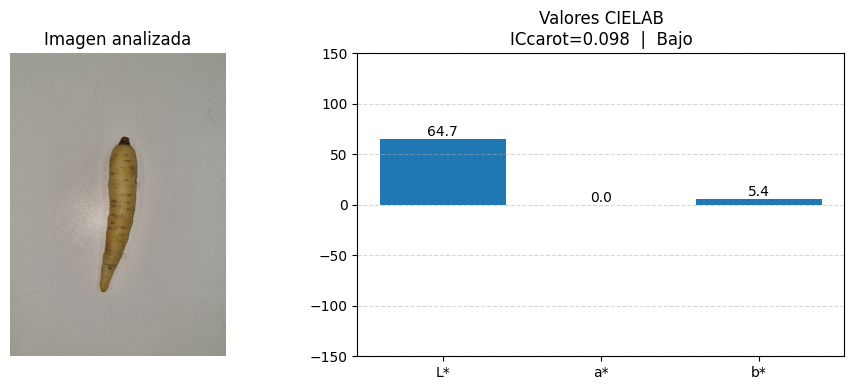

In [30]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# -------- 1. Procesar imagen: obtener L*, a*, b* promedio --------
def procesar_imagen(ruta_imagen):
    """
    Extrae valores promedio L*, a*, b* de una imagen en espacio CIELAB.
    """
    try:
        img = cv2.imread(ruta_imagen)
        if img is None:
            raise ValueError("No se pudo leer la imagen")

        # Redimensionar si es muy grande
        if max(img.shape) > 1000:
            img = cv2.resize(img, (500, 500))

        # BGR -> LAB
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Promedios
        L = np.mean(img_lab[:, :, 0]) * 100 / 255
        a = np.mean(img_lab[:, :, 1]) - 128
        b = np.mean(img_lab[:, :, 2]) - 128

        return {'L': L, 'a': a, 'b': b}
    except Exception as e:
        print(f"Error procesando imagen: {str(e)}")
        return None


# -------- 2. Predicción: ppm + ICcarot + categoría --------
def predecir_carotenoides(valores_color):
    """
    Usa el modelo rf_model para predecir carotenoides (ppm) y
    el índice ICcarot para clasificar en Bajo/Medio/Alto.
    Requiere que rf_model, b_max, a_max, C_max, umbral_ic_bajo, umbral_ic_medio
    estén definidos en el entorno.
    """
    try:
        L, a, b = valores_color['L'], valores_color['a'], valores_color['b']

        # 1) Predicción de ppm con Random Forest
        X_new = np.array([[L, a, b]])
        ppm = rf_model.predict(X_new)[0]

        # 2) Calcular C* e ICcarot
        C = np.sqrt(a**2 + b**2)
        ICcarot = (
            0.7 * (b / b_max) +
            0.2 * (a / a_max) +
            0.1 * (C / C_max)
        )

        # 3) Clasificación según ICcarot
        if ICcarot <= umbral_ic_bajo:
            categoria = "Bajo"
        elif ICcarot <= umbral_ic_medio:
            categoria = "Medio"
        else:
            categoria = "Alto"

        return {
            'valores_lab': {
                'L': round(L, 1),
                'a': round(a, 1),
                'b': round(b, 1)
            },
            'ppm': round(float(ppm), 2),
            'ICcarot': round(float(ICcarot), 3),
            'categoria': categoria
        }

    except Exception as e:
        print(f"Error en predicción: {str(e)}")
        return None


# -------- 3. Función para subir imagen y ver resultados --------
def ejecutar_prediccion_desde_imagen():
    print("Sube una imagen de zanahoria (JPG/PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("No se subió ninguna imagen.")
        return

    # Tomar el primer archivo subido
    ruta = next(iter(uploaded))

    # 1) Extraer L*, a*, b*
    valores = procesar_imagen(ruta)
    if not valores:
        return

    # 2) Predecir carotenoides e índice
    resultado = predecir_carotenoides(valores)
    if not resultado:
        return

    # 3) Mostrar resultados numéricos
    print("\n=== RESULTADO DEL MODELO ===")
    print(f"L* = {resultado['valores_lab']['L']}")
    print(f"a* = {resultado['valores_lab']['a']}")
    print(f"b* = {resultado['valores_lab']['b']}")
    print(f"ICcarot = {resultado['ICcarot']}")
    print(f"Carotenoides estimados = {resultado['ppm']} ppm")
    print(f"Categoría = {resultado['categoria']}")

    # 4) Visualización gráfica
    plt.figure(figsize=(10, 4))

    # Imagen original
    plt.subplot(1, 2, 1)
    img = cv2.imread(ruta)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("Imagen analizada")
    plt.axis('off')

    # Barras LAB
    plt.subplot(1, 2, 2)
    vals = resultado['valores_lab']
    barras = plt.bar(['L*', 'a*', 'b*'], [vals['L'], vals['a'], vals['b']])

    for bar in barras:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h,
                 f'{h:.1f}', ha='center', va='bottom')

    plt.title(f"Valores CIELAB\nICcarot={resultado['ICcarot']}  |  {resultado['categoria']}")
    plt.ylim(-150, 150)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# Llamar a la función para probar
ejecutar_prediccion_desde_imagen()


Sube una imagen de zanahoria (JPG/PNG):


Saving Copia de 20240229_093911.jpg to Copia de 20240229_093911 (1).jpg

=== RESULTADO DEL MODELO ===
L* = 63.4
a* = -0.7
b* = 6.8
ICcarot = 0.119
Carotenoides estimados = 0.47 ppm
Categoría = Bajo


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


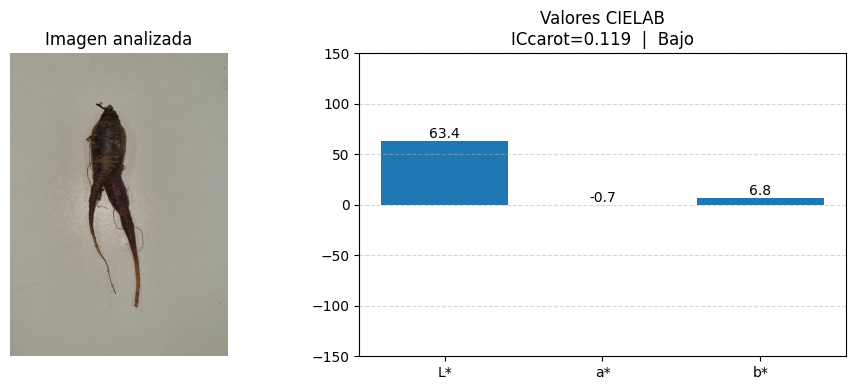

In [31]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# -------- 1. Procesar imagen: obtener L*, a*, b* promedio --------
def procesar_imagen(ruta_imagen):
    """
    Extrae valores promedio L*, a*, b* de una imagen en espacio CIELAB.
    """
    try:
        img = cv2.imread(ruta_imagen)
        if img is None:
            raise ValueError("No se pudo leer la imagen")

        # Redimensionar si es muy grande
        if max(img.shape) > 1000:
            img = cv2.resize(img, (500, 500))

        # BGR -> LAB
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Promedios
        L = np.mean(img_lab[:, :, 0]) * 100 / 255
        a = np.mean(img_lab[:, :, 1]) - 128
        b = np.mean(img_lab[:, :, 2]) - 128

        return {'L': L, 'a': a, 'b': b}
    except Exception as e:
        print(f"Error procesando imagen: {str(e)}")
        return None


# -------- 2. Predicción: ppm + ICcarot + categoría --------
def predecir_carotenoides(valores_color):
    """
    Usa el modelo rf_model para predecir carotenoides (ppm) y
    el índice ICcarot para clasificar en Bajo/Medio/Alto.
    Requiere que rf_model, b_max, a_max, C_max, umbral_ic_bajo, umbral_ic_medio
    estén definidos en el entorno.
    """
    try:
        L, a, b = valores_color['L'], valores_color['a'], valores_color['b']

        # 1) Predicción de ppm con Random Forest
        X_new = np.array([[L, a, b]])
        ppm = rf_model.predict(X_new)[0]

        # 2) Calcular C* e ICcarot
        C = np.sqrt(a**2 + b**2)
        ICcarot = (
            0.7 * (b / b_max) +
            0.2 * (a / a_max) +
            0.1 * (C / C_max)
        )

        # 3) Clasificación según ICcarot
        if ICcarot <= umbral_ic_bajo:
            categoria = "Bajo"
        elif ICcarot <= umbral_ic_medio:
            categoria = "Medio"
        else:
            categoria = "Alto"

        return {
            'valores_lab': {
                'L': round(L, 1),
                'a': round(a, 1),
                'b': round(b, 1)
            },
            'ppm': round(float(ppm), 2),
            'ICcarot': round(float(ICcarot), 3),
            'categoria': categoria
        }

    except Exception as e:
        print(f"Error en predicción: {str(e)}")
        return None


# -------- 3. Función para subir imagen y ver resultados --------
def ejecutar_prediccion_desde_imagen():
    print("Sube una imagen de zanahoria (JPG/PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("No se subió ninguna imagen.")
        return

    # Tomar el primer archivo subido
    ruta = next(iter(uploaded))

    # 1) Extraer L*, a*, b*
    valores = procesar_imagen(ruta)
    if not valores:
        return

    # 2) Predecir carotenoides e índice
    resultado = predecir_carotenoides(valores)
    if not resultado:
        return

    # 3) Mostrar resultados numéricos
    print("\n=== RESULTADO DEL MODELO ===")
    print(f"L* = {resultado['valores_lab']['L']}")
    print(f"a* = {resultado['valores_lab']['a']}")
    print(f"b* = {resultado['valores_lab']['b']}")
    print(f"ICcarot = {resultado['ICcarot']}")
    print(f"Carotenoides estimados = {resultado['ppm']} ppm")
    print(f"Categoría = {resultado['categoria']}")

    # 4) Visualización gráfica
    plt.figure(figsize=(10, 4))

    # Imagen original
    plt.subplot(1, 2, 1)
    img = cv2.imread(ruta)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("Imagen analizada")
    plt.axis('off')

    # Barras LAB
    plt.subplot(1, 2, 2)
    vals = resultado['valores_lab']
    barras = plt.bar(['L*', 'a*', 'b*'], [vals['L'], vals['a'], vals['b']])

    for bar in barras:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h,
                 f'{h:.1f}', ha='center', va='bottom')

    plt.title(f"Valores CIELAB\nICcarot={resultado['ICcarot']}  |  {resultado['categoria']}")
    plt.ylim(-150, 150)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# Llamar a la función para probar
ejecutar_prediccion_desde_imagen()


Sube una imagen de zanahoria (JPG/PNG):


Saving Copia de 20240229_100536.jpg to Copia de 20240229_100536.jpg

=== RESULTADO DEL MODELO ===
L* = 66.0
a* = 0.7
b* = 7.9
ICcarot = 0.148
Carotenoides estimados = 0.47 ppm
Categoría = Bajo


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


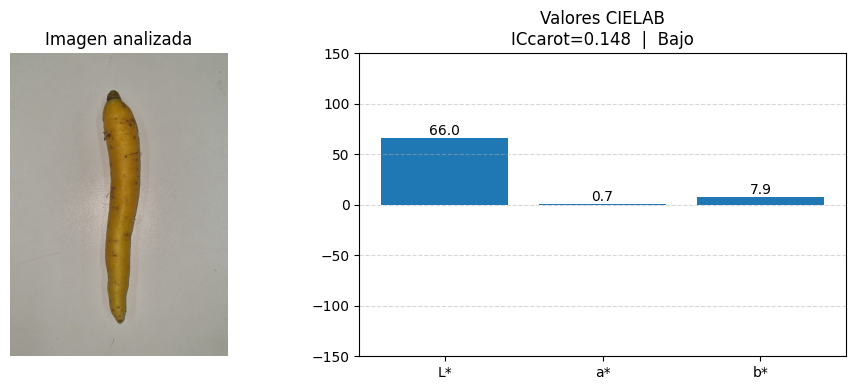

In [32]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# -------- 1. Procesar imagen: obtener L*, a*, b* promedio --------
def procesar_imagen(ruta_imagen):
    """
    Extrae valores promedio L*, a*, b* de una imagen en espacio CIELAB.
    """
    try:
        img = cv2.imread(ruta_imagen)
        if img is None:
            raise ValueError("No se pudo leer la imagen")

        # Redimensionar si es muy grande
        if max(img.shape) > 1000:
            img = cv2.resize(img, (500, 500))

        # BGR -> LAB
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Promedios
        L = np.mean(img_lab[:, :, 0]) * 100 / 255
        a = np.mean(img_lab[:, :, 1]) - 128
        b = np.mean(img_lab[:, :, 2]) - 128

        return {'L': L, 'a': a, 'b': b}
    except Exception as e:
        print(f"Error procesando imagen: {str(e)}")
        return None


# -------- 2. Predicción: ppm + ICcarot + categoría --------
def predecir_carotenoides(valores_color):
    """
    Usa el modelo rf_model para predecir carotenoides (ppm) y
    el índice ICcarot para clasificar en Bajo/Medio/Alto.
    Requiere que rf_model, b_max, a_max, C_max, umbral_ic_bajo, umbral_ic_medio
    estén definidos en el entorno.
    """
    try:
        L, a, b = valores_color['L'], valores_color['a'], valores_color['b']

        # 1) Predicción de ppm con Random Forest
        X_new = np.array([[L, a, b]])
        ppm = rf_model.predict(X_new)[0]

        # 2) Calcular C* e ICcarot
        C = np.sqrt(a**2 + b**2)
        ICcarot = (
            0.7 * (b / b_max) +
            0.2 * (a / a_max) +
            0.1 * (C / C_max)
        )

        # 3) Clasificación según ICcarot
        if ICcarot <= umbral_ic_bajo:
            categoria = "Bajo"
        elif ICcarot <= umbral_ic_medio:
            categoria = "Medio"
        else:
            categoria = "Alto"

        return {
            'valores_lab': {
                'L': round(L, 1),
                'a': round(a, 1),
                'b': round(b, 1)
            },
            'ppm': round(float(ppm), 2),
            'ICcarot': round(float(ICcarot), 3),
            'categoria': categoria
        }

    except Exception as e:
        print(f"Error en predicción: {str(e)}")
        return None


# -------- 3. Función para subir imagen y ver resultados --------
def ejecutar_prediccion_desde_imagen():
    print("Sube una imagen de zanahoria (JPG/PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("No se subió ninguna imagen.")
        return

    # Tomar el primer archivo subido
    ruta = next(iter(uploaded))

    # 1) Extraer L*, a*, b*
    valores = procesar_imagen(ruta)
    if not valores:
        return

    # 2) Predecir carotenoides e índice
    resultado = predecir_carotenoides(valores)
    if not resultado:
        return

    # 3) Mostrar resultados numéricos
    print("\n=== RESULTADO DEL MODELO ===")
    print(f"L* = {resultado['valores_lab']['L']}")
    print(f"a* = {resultado['valores_lab']['a']}")
    print(f"b* = {resultado['valores_lab']['b']}")
    print(f"ICcarot = {resultado['ICcarot']}")
    print(f"Carotenoides estimados = {resultado['ppm']} ppm")
    print(f"Categoría = {resultado['categoria']}")

    # 4) Visualización gráfica
    plt.figure(figsize=(10, 4))

    # Imagen original
    plt.subplot(1, 2, 1)
    img = cv2.imread(ruta)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("Imagen analizada")
    plt.axis('off')

    # Barras LAB
    plt.subplot(1, 2, 2)
    vals = resultado['valores_lab']
    barras = plt.bar(['L*', 'a*', 'b*'], [vals['L'], vals['a'], vals['b']])

    for bar in barras:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h,
                 f'{h:.1f}', ha='center', va='bottom')

    plt.title(f"Valores CIELAB\nICcarot={resultado['ICcarot']}  |  {resultado['categoria']}")
    plt.ylim(-150, 150)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# Llamar a la función para probar
ejecutar_prediccion_desde_imagen()


Sube una imagen de zanahoria (JPG/PNG):


Saving photo-4.jpg to photo-4.jpg

=== RESULTADO DEL MODELO ===
L* = 86.6
a* = 7.3
b* = 8.9
ICcarot = 0.225
Carotenoides estimados = 0.47 ppm
Categoría = Bajo


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


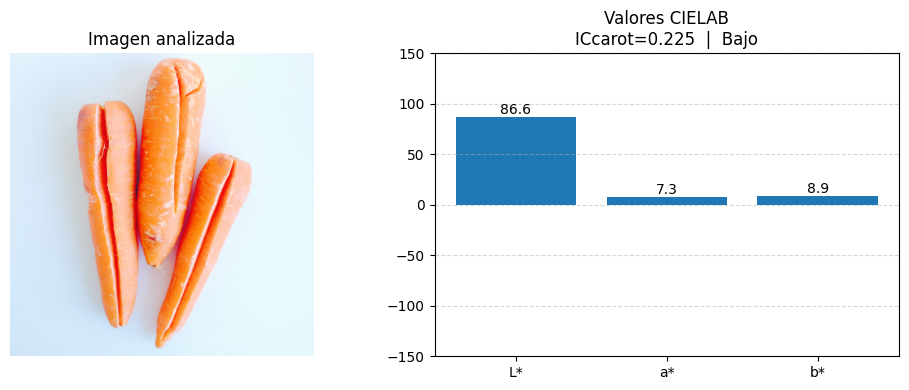

In [34]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

# -------- 1. Procesar imagen: obtener L*, a*, b* promedio --------
def procesar_imagen(ruta_imagen):
    """
    Extrae valores promedio L*, a*, b* de una imagen en espacio CIELAB.
    """
    try:
        img = cv2.imread(ruta_imagen)
        if img is None:
            raise ValueError("No se pudo leer la imagen")

        # Redimensionar si es muy grande
        if max(img.shape) > 1000:
            img = cv2.resize(img, (500, 500))

        # BGR -> LAB
        img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

        # Promedios
        L = np.mean(img_lab[:, :, 0]) * 100 / 255
        a = np.mean(img_lab[:, :, 1]) - 128
        b = np.mean(img_lab[:, :, 2]) - 128

        return {'L': L, 'a': a, 'b': b}
    except Exception as e:
        print(f"Error procesando imagen: {str(e)}")
        return None


# -------- 2. Predicción: ppm + ICcarot + categoría --------
def predecir_carotenoides(valores_color):
    """
    Usa el modelo rf_model para predecir carotenoides (ppm) y
    el índice ICcarot para clasificar en Bajo/Medio/Alto.
    Requiere que rf_model, b_max, a_max, C_max, umbral_ic_bajo, umbral_ic_medio
    estén definidos en el entorno.
    """
    try:
        L, a, b = valores_color['L'], valores_color['a'], valores_color['b']

        # 1) Predicción de ppm con Random Forest
        X_new = np.array([[L, a, b]])
        ppm = rf_model.predict(X_new)[0]

        # 2) Calcular C* e ICcarot
        C = np.sqrt(a**2 + b**2)
        ICcarot = (
            0.7 * (b / b_max) +
            0.2 * (a / a_max) +
            0.1 * (C / C_max)
        )

        # 3) Clasificación según ICcarot
        if ICcarot <= umbral_ic_bajo:
            categoria = "Bajo"
        elif ICcarot <= umbral_ic_medio:
            categoria = "Medio"
        else:
            categoria = "Alto"

        return {
            'valores_lab': {
                'L': round(L, 1),
                'a': round(a, 1),
                'b': round(b, 1)
            },
            'ppm': round(float(ppm), 2),
            'ICcarot': round(float(ICcarot), 3),
            'categoria': categoria
        }

    except Exception as e:
        print(f"Error en predicción: {str(e)}")
        return None


# -------- 3. Función para subir imagen y ver resultados --------
def ejecutar_prediccion_desde_imagen():
    print("Sube una imagen de zanahoria (JPG/PNG):")
    uploaded = files.upload()

    if not uploaded:
        print("No se subió ninguna imagen.")
        return

    # Tomar el primer archivo subido
    ruta = next(iter(uploaded))

    # 1) Extraer L*, a*, b*
    valores = procesar_imagen(ruta)
    if not valores:
        return

    # 2) Predecir carotenoides e índice
    resultado = predecir_carotenoides(valores)
    if not resultado:
        return

    # 3) Mostrar resultados numéricos
    print("\n=== RESULTADO DEL MODELO ===")
    print(f"L* = {resultado['valores_lab']['L']}")
    print(f"a* = {resultado['valores_lab']['a']}")
    print(f"b* = {resultado['valores_lab']['b']}")
    print(f"ICcarot = {resultado['ICcarot']}")
    print(f"Carotenoides estimados = {resultado['ppm']} ppm")
    print(f"Categoría = {resultado['categoria']}")

    # 4) Visualización gráfica
    plt.figure(figsize=(10, 4))

    # Imagen original
    plt.subplot(1, 2, 1)
    img = cv2.imread(ruta)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("Imagen analizada")
    plt.axis('off')

    # Barras LAB
    plt.subplot(1, 2, 2)
    vals = resultado['valores_lab']
    barras = plt.bar(['L*', 'a*', 'b*'], [vals['L'], vals['a'], vals['b']])

    for bar in barras:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., h,
                 f'{h:.1f}', ha='center', va='bottom')

    plt.title(f"Valores CIELAB\nICcarot={resultado['ICcarot']}  |  {resultado['categoria']}")
    plt.ylim(-150, 150)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


# Llamar a la función para probar
ejecutar_prediccion_desde_imagen()


In [ ]:
# Ahora sí puedes usar la columna ICarot_v2
merged_data['Categoria'] = pd.qcut(
    merged_data['ICarot_v2'],
    q=[0, 0.25, 0.75, 1],
    labels=['Bajo', 'Medio', 'Alto']
)

# Mostrar resultados
print(merged_data[['Material', 'ICarot_v2', 'Categoria', 'ppmRefri']].sort_values('ICarot_v2', ascending=False))

   Material  ICarot_v2 Categoria   ppmRefri
55    14BER   0.989584      Alto  31.846504
54    14BER   0.989584      Alto  29.397283
53    14BER   0.989584      Alto  39.194169
52    14BER   0.989584      Alto  83.280156
68     6KUR   0.904639      Alto  81.565701
..      ...        ...       ...        ...
39   Blanca   0.113284      Bajo   0.000000
16   Blanca   0.111135      Bajo   4.905068
17   Blanca   0.111135      Bajo   2.000000
18   Blanca   0.111135      Bajo   1.400000
19   Blanca   0.111135      Bajo   0.000000

[80 rows x 4 columns]


In [ ]:
# Verificar existencia de columnas requeridas
required_cols = ['a', 'b', 'C']
if all(col in merged_data.columns for col in required_cols):
    merged_data['ICarot_v2'] = 0.5*(merged_data['a']/20) + 0.3*(merged_data['b']/60) + 0.2*(merged_data['C']/50)
    merged_data['Categoria'] = pd.qcut(merged_data['ICarot_v2'],
                                     q=[0, 0.25, 0.75, 1],
                                     labels=['Bajo', 'Medio', 'Alto'])
    display(merged_data.head())
else:
    print(f"Faltan columnas: {[col for col in required_cols if col not in merged_data.columns]}")

,Dia_muestreo_x,Material,Repeticion,L,a,b,C,h,Dia_muestreo_y,AbsorbanciaRefri,AbsorbanciaTam,ppmRefri,ppmTam,YI,h°,b_norm,C_norm,ICarot,Categoria,ICarot_v2
0,2024-10-09,Morada,1,26.93,2.82,4.83,5.592969,59.721441,2024-10-09,0.120,0.110,7.354289,4.905068,25.622495,59.721441,0.000000,0.000000,0.000000,Bajo,0.117022
1,2024-10-09,Morada,1,26.93,2.82,4.83,5.592969,59.721441,2024-10-16,0.110,0.100,4.905068,2.455846,25.622495,59.721441,0.000000,0.000000,0.000000,Bajo,0.117022
2,2024-10-09,Morada,1,26.93,2.82,4.83,5.592969,59.721441,2024-10-23,0.109,0.105,4.660146,3.680457,25.622495,59.721441,0.000000,0.000000,0.000000,Bajo,0.117022
3,2024-10-09,Morada,1,26.93,2.82,4.83,5.592969,59.721441,2024-10-30,0.110,0.100,4.905068,2.455846,25.622495,59.721441,0.000000,0.000000,0.000000,Bajo,0.117022
4,2024-10-09,Amarilla,1,59.33,2.02,39.34,39.391827,87.060602,2024-10-09,0.110,0.110,4.905068,4.905068,94.726317,87.060602,0.947036,0.834736,0.902116,Medio,0.404767


**VARIABLE TEMPORAL**

In [ ]:
# 1. Verificar las columnas disponibles
print("Columnas existentes en merged_data:")
print(merged_data.columns.tolist())

# 2. Verificar si las columnas necesarias ('b' y 'C') existen
required_cols = ['b', 'C']
missing_cols = [col for col in required_cols if col not in merged_data.columns]

if missing_cols:
    print(f"\n¡Columnas faltantes: {missing_cols}!")
    print("No se puede calcular ICarot_v2 sin estas columnas.")
else:
    # 3. Calcular el índice ICarot_v2 (versión robusta)
    try:
        # Usar valores máximos reales de tus datos en lugar de valores fijos (60 y 50)
        max_b = merged_data['b'].max()
        max_C = merged_data['C'].max()

        merged_data['ICarot_v2'] = (
            0.6 * (merged_data['b'] / max_b) +
            0.4 * (merged_data['C'] / max_C)
        )

        # 4. Verificación (usando columnas disponibles)
        available_cols = [col for col in ['Material', 'Repeticion', 'ICarot_v2'] if col in merged_data.columns]
        if available_cols:
            print("\nPrimeras filas con ICarot_v2 calculado:")
            print(merged_data[available_cols].head())
        else:
            print("\nICarot_v2 calculado pero no hay columnas comunes para mostrar")

    except Exception as e:
        print(f"\nError al calcular ICarot_v2: {e}")

# 5. Si necesitas reconstruir 'Dia_muestreo':
if 'Dia_muestreo' not in merged_data.columns and 'Dia_muestreo' in color_data.columns:
    print("\nReconstruyendo columna 'Dia_muestreo' desde color_data...")
    merged_data = pd.merge(
        merged_data,
        color_data[['Material', 'Repeticion', 'Dia_muestreo']],
        on=['Material', 'Repeticion'],
        how='left'
    )
    print("¡Columna agregada! Nuevas columnas:", merged_data.columns.tolist())

Columnas existentes en merged_data:
['Dia_muestreo_x', 'Material', 'Repeticion', 'L', 'a', 'b', 'C', 'h', 'Dia_muestreo_y', 'AbsorbanciaRefri', 'AbsorbanciaTam', 'ppmRefri', 'ppmTam', 'YI', 'h°', 'b_norm', 'C_norm', 'ICarot', 'Categoria', 'ICarot_v2']

Primeras filas con ICarot_v2 calculado:
   Material  Repeticion  ICarot_v2
0    Morada           1   0.118767
1    Morada           1   0.118767
2    Morada           1   0.118767
3    Morada           1   0.118767
4  Amarilla           1   0.913858

Reconstruyendo columna 'Dia_muestreo' desde color_data...
¡Columna agregada! Nuevas columnas: ['Dia_muestreo_x', 'Material', 'Repeticion', 'L', 'a', 'b', 'C', 'h', 'Dia_muestreo_y', 'AbsorbanciaRefri', 'AbsorbanciaTam', 'ppmRefri', 'ppmTam', 'YI', 'h°', 'b_norm', 'C_norm', 'ICarot', 'Categoria', 'ICarot_v2', 'Dia_muestreo']


In [ ]:
# Calcular máximos reales de tus datos
max_b = merged_data['b'].max()  # Ejemplo: podría ser 39.34 en tus datos
max_C = merged_data['C'].max()  # Ejemplo: podría ser 37.21

# Fórmula ajustada con tus máximos reales
merged_data['ICarot_v2'] = (
    0.6 * (merged_data['b'] / max_b) +
    0.4 * (merged_data['C'] / max_C)
)

# Verificar rango
print("Rango del índice:", merged_data['ICarot_v2'].min(), merged_data['ICarot_v2'].max())

Rango del índice: 0.11876696675646711 0.9684516598013084


In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=merged_data,
    x='Semana',
    y='ICarot_v2',
    hue='Material',
    style='Material',
    markers=True,
    dashes=False,
    linewidth=2,
    markersize=10
)
plt.title('Evolución Semanal del Índice ICarot_v2 (0-1)', fontsize=14)
plt.xlabel('Semana del Año', fontsize=12)
plt.ylabel('Valor del Índice (Normalizado)', fontsize=12)
plt.ylim(0, 1.1)  # Fijar rango Y entre 0 y 1
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `Semana` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Si 'b' es más importante que 'C' (basado en correlaciones)
merged_data['ICarot_v3'] = 0.7 * (merged_data['b'] / max_b) + 0.3 * (merged_data['C'] / max_C)

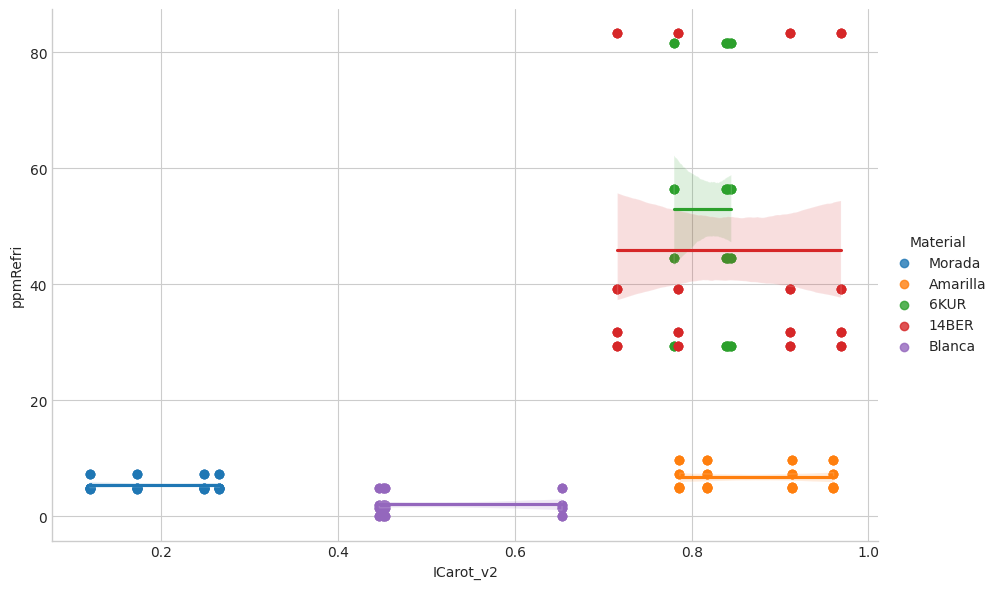

In [ ]:
sns.lmplot(
    data=merged_data,
    x='ICarot_v2',
    y='ppmRefri',
    hue='Material',
    height=6,
    aspect=1.5
)

In [ ]:
# Calcular máximos para normalización
max_a = merged_data['a'].max()  # Máximo valor de a* en tus datos
max_b = merged_data['b'].max()  # Máximo valor de b* en tus datos
max_C = merged_data['C'].max()  # Máximo valor de Croma

print(f"Valores máximos: a*={max_a}, b*={max_b}, C={max_C}")

Valores máximos: a*=24.39, b*=41.27, C=46.083425436918205


In [ ]:
# Versión con a* incluido (ajusta los coeficientes según necesidad)
merged_data['ICarot_v3'] = (
    0.7 * (merged_data['b'] / max_b) +
    0.2 * (merged_data['a'] / max_a) +
    0.1 * (merged_data['C'] / max_C)
)

# Verificar rango (debería ser 0-1)
print("Rango del ICarot_v3:", merged_data['ICarot_v3'].min(), merged_data['ICarot_v3'].max())

Rango del ICarot_v3: 0.117184763820695 0.9631936031015264


/tmp/ipython-input-2837827907.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


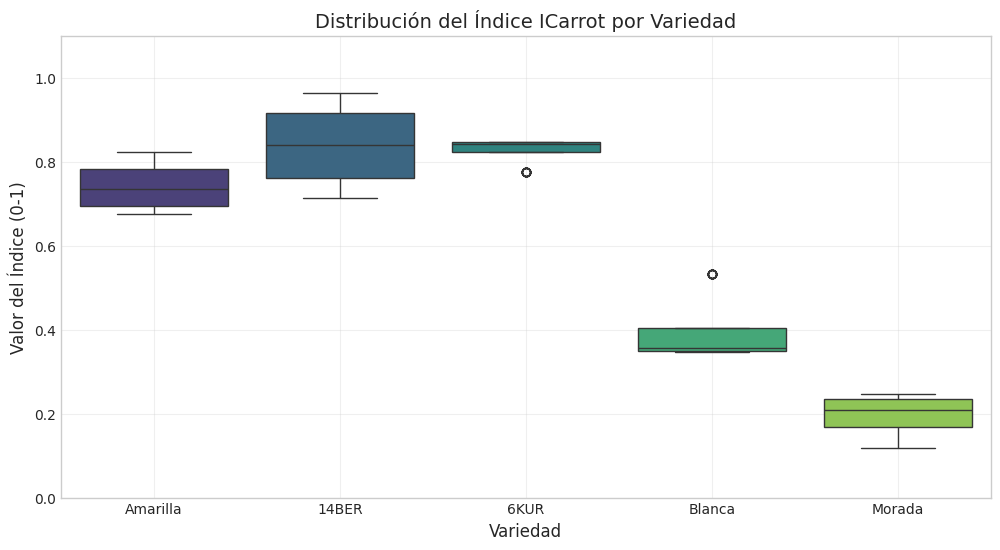

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_data,
    x='Material',
    y='ICarot_v3',
    palette='viridis',
    order=['Amarilla', '14BER', '6KUR', 'Blanca','Morada']  # Orden descendente esperado
)
plt.title('Distribución del Índice ICarrot por Variedad', fontsize=14)
plt.xlabel('Variedad', fontsize=12)
plt.ylabel('Valor del Índice (0-1)', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(alpha=0.3)
plt.show()

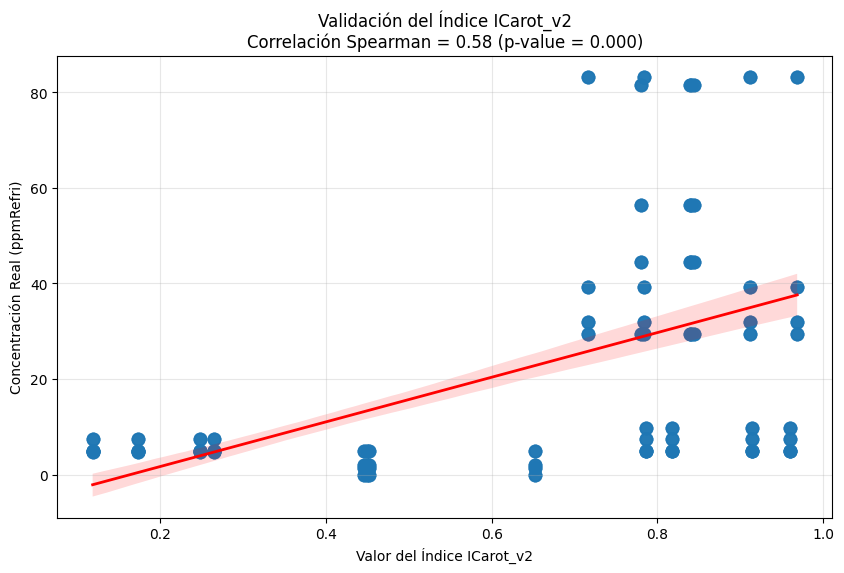

AttributeError: 'Series' object has no attribute 'scale'

In [ ]:
# 6. Validación del índice contra la variable objetivo (ppmRefri)
from scipy.stats import spearmanr

corr, p_value = spearmanr(merged_data['ICarot_v2'], merged_data['ppmRefri'])

plt.figure(figsize=(10, 6))
sns.regplot(
    data=merged_data,
    x='ICarot_v2',
    y='ppmRefri',
    scatter_kws={'s': 80, 'alpha': 0.6},
    line_kws={'color': 'red', 'linewidth': 2}
)
plt.title(f'Validación del Índice ICarot_v2\nCorrelación Spearman = {corr:.2f} (p-value = {p_value:.3f})')
plt.xlabel('Valor del Índice ICarot_v2')
plt.ylabel('Concentración Real (ppmRefri)')
plt.grid(alpha=0.3)
plt.show()

# 7. Análisis de residuales (Diferencia entre índice y valor real)
merged_data['Residual'] = merged_data['ppmRefri'] - merged_data['ICarot_v2'].scale()  # Escalado para comparabilidad

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_data,
    x='Material',
    y='Residual',
    palette='viridis'
)
plt.axhline(0, color='red', linestyle='--')
plt.title('Error del Índice por Material (Residuales)')
plt.ylabel('Diferencia entre Real y Estimado')
plt.xticks(rotation=45)
plt.show()

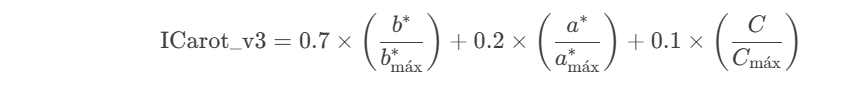

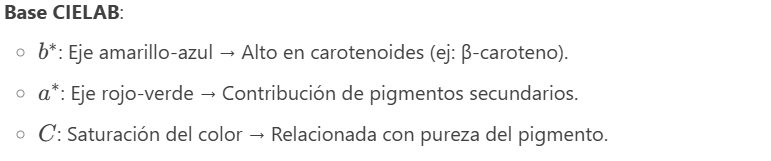*texto en cursiva*

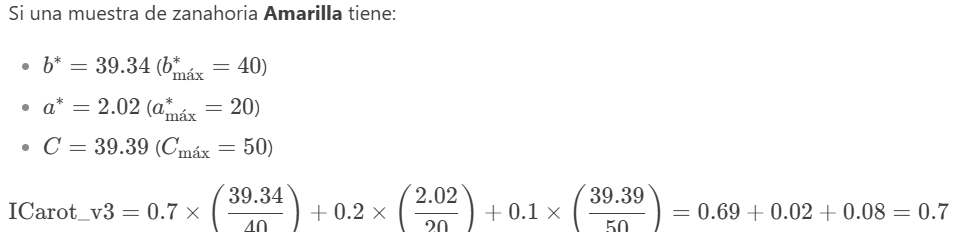

Datos de color cargados correctamente. Columnas: ['Dia_muestreo', 'Material', 'Repeticion', 'L', 'a', 'b']

Datos de concentración cargados correctamente. Columnas: ['Dia_muestreo', 'Material', 'Replica', 'AbsorbanciaRefri', 'AbsorbanciaTam', 'ppmRefri', 'ppmTam']

Merge exitoso. Tamaño del dataset combinado: (20, 13)

Matriz de correlación:
ppmRefri    1.000000
a           0.801368
C           0.648798
YI          0.632182
b           0.479612
L          -0.360276
h          -0.686563
Name: ppmRefri, dtype: float64


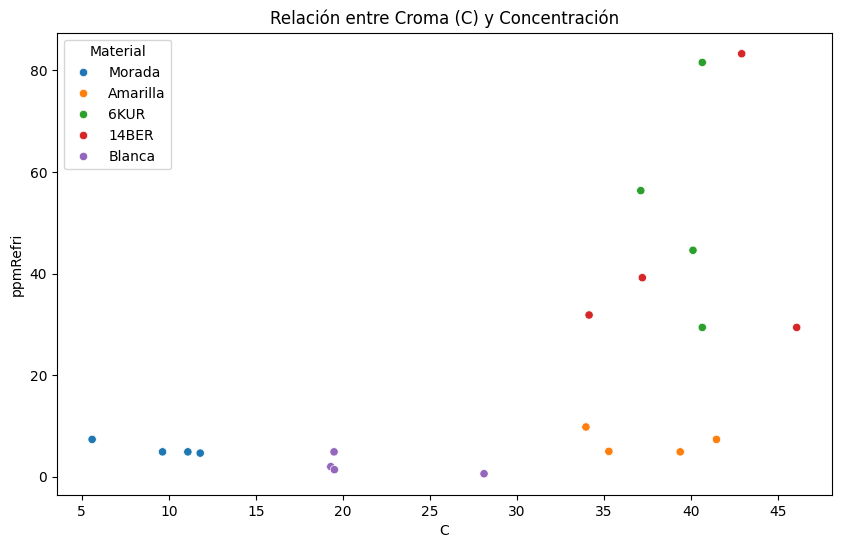

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Cargar datos con verificación
try:
    color_path = '/content/drive/MyDrive/Colab Notebooks/Espectral/COLOR.xlsx'
    color_data = pd.read_excel(color_path)
    print("Datos de color cargados correctamente. Columnas:", color_data.columns.tolist())
except Exception as e:
    print("Error cargando datos de color:", e)

try:
    conc_path = '/content/drive/MyDrive/TESIS_ZANAHORIA/Espectral/Semana1_concentraciones.xlsx'
    conc_data = pd.read_excel(conc_path)
    print("\nDatos de concentración cargados correctamente. Columnas:", conc_data.columns.tolist())
except Exception as e:
    print("Error cargando datos de concentración:", e)

# 2. Preprocesamiento básico
# Verificar y estandarizar nombres de columnas
conc_data = conc_data.rename(columns={'Replica': 'Repeticion'})

# Calcular variables de color si las columnas existen
if all(col in color_data.columns for col in ['a', 'b', 'L']):
    color_data['C'] = np.sqrt(color_data['a']**2 + color_data['b']**2)  # Croma
    color_data['h'] = np.arctan2(color_data['b'], color_data['a']) * (180 / np.pi)  # Ángulo Hue
    color_data['YI'] = (142.86 * color_data['b']) / color_data['L']  # Índice de amarillez
else:
    print("Columnas 'a', 'b' o 'L' no encontradas en color_data")

# 3. Unir datos con verificación
try:
    merged_data = pd.merge(
        color_data,
        conc_data,
        on=['Material', 'Repeticion', 'Dia_muestreo'],
        how='inner'
    )
    print("\nMerge exitoso. Tamaño del dataset combinado:", merged_data.shape)
except Exception as e:
    print("\nError en el merge:", e)
    # Alternativa: concatenar columnas si el merge falla
    merged_data = pd.concat([color_data, conc_data], axis=1)
    print("Se concatenaron columnas en su lugar. Tamaño:", merged_data.shape)

# 4. Análisis y visualización (solo si tenemos datos)
if not merged_data.empty:
    # Matriz de correlación
    corr_vars = ['L', 'a', 'b', 'C', 'h', 'YI', 'ppmRefri']
    corr_matrix = merged_data[corr_vars].corr(method='spearman')
    print("\nMatriz de correlación:")
    print(corr_matrix['ppmRefri'].sort_values(ascending=False))

    # Visualización
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=merged_data, x='C', y='ppmRefri', hue='Material')
    plt.title('Relación entre Croma (C) y Concentración')
    plt.show()
else:
    print("\nNo hay datos para analizar. Verifica los pasos anteriores.")

Correlaciones con ppmRefri:
ppmRefri    1.000000
a           0.801368
C           0.648798
YI          0.632182
b           0.479612
L          -0.360276
h          -0.686563
Name: ppmRefri, dtype: float64


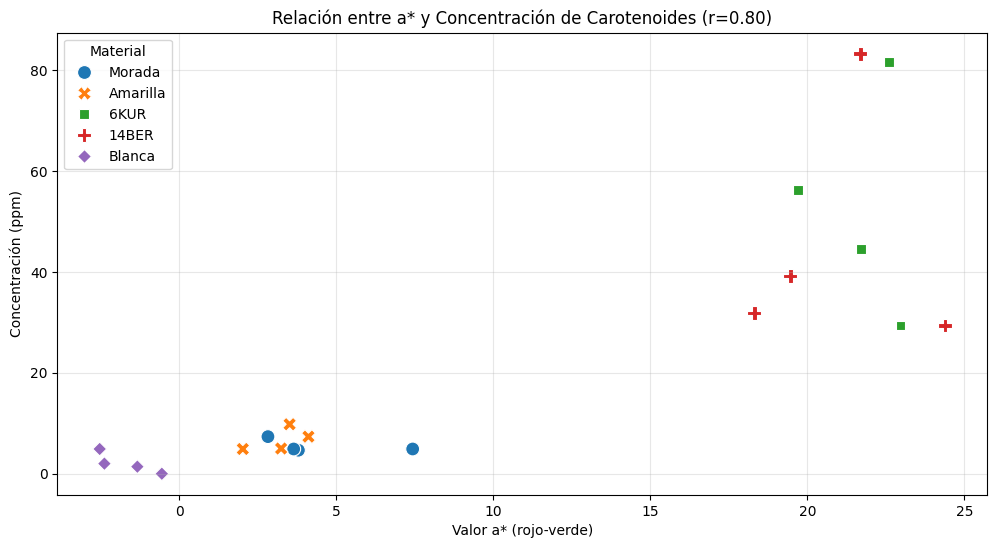


R² Entrenamiento: 0.927
R² Prueba: -0.499

Importancia de variables:
a     0.583134
h     0.152548
L     0.088568
YI    0.075179
C     0.072065
b     0.028505
dtype: float64

Variables seleccionadas para el índice: ['a', 'h']


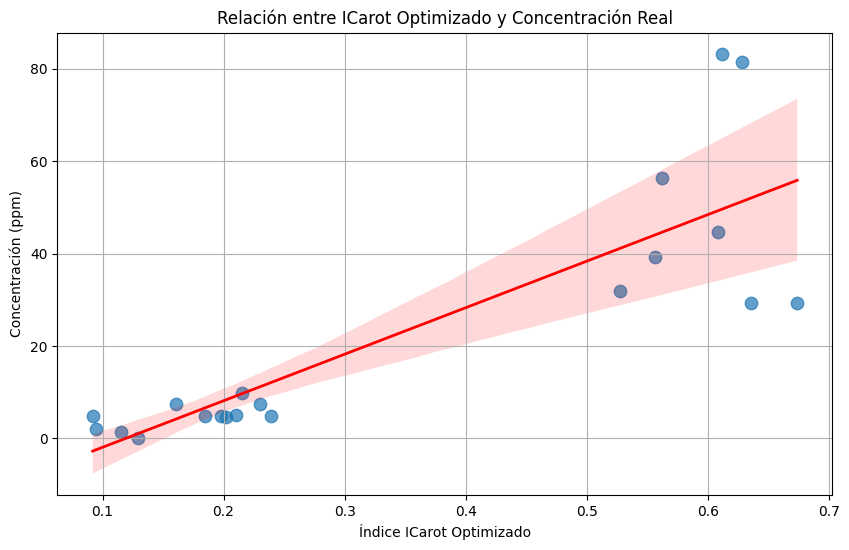

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# 1. Cargar datos (ya confirmado que funciona)
color_path = '/content/drive/MyDrive/Colab Notebooks/Espectral/COLOR.xlsx'
conc_path = '/content/drive/MyDrive/TESIS_ZANAHORIA/Espectral/Semana1_concentraciones.xlsx'

color_data = pd.read_excel(color_path)
conc_data = pd.read_excel(conc_path)

# 2. Estandarizar nombres de columnas
conc_data = conc_data.rename(columns={'Replica': 'Repeticion'})

# 3. Calcular variables de color
color_data['C'] = np.sqrt(color_data['a']**2 + color_data['b']**2)  # Croma
color_data['h'] = np.arctan2(color_data['b'], color_data['a']) * (180/np.pi)  # Ángulo Hue
color_data['YI'] = (142.86 * color_data['b']) / color_data['L']  # Índice de amarillez

# 4. Unir datos
merged_data = pd.merge(
    color_data,
    conc_data,
    on=['Dia_muestreo', 'Material', 'Repeticion'],
    how='inner'
)

# 5. Análisis de correlación (actualizado)
corr_vars = ['L', 'a', 'b', 'C', 'h', 'YI', 'ppmRefri']
corr_matrix = merged_data[corr_vars].corr(method='spearman')

print("Correlaciones con ppmRefri:")
print(corr_matrix['ppmRefri'].sort_values(ascending=False))

# 6. Visualización clave
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=merged_data,
    x='a',  # Variable con mayor correlación (0.80)
    y='ppmRefri',
    hue='Material',
    style='Material',
    s=100
)
plt.title('Relación entre a* y Concentración de Carotenoides (r=0.80)')
plt.xlabel('Valor a* (rojo-verde)')
plt.ylabel('Concentración (ppm)')
plt.grid(alpha=0.3)
plt.show()

# 7. Modelo predictivo mejorado
X = merged_data[['L', 'a', 'b', 'C', 'h', 'YI']]
y = merged_data['ppmRefri']

# Eliminar filas con valores nulos si existen
X = X.dropna()
y = y[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

print(f"\nR² Entrenamiento: {rf.score(X_train, y_train):.3f}")
print(f"R² Prueba: {rf.score(X_test, y_test):.3f}")

# 8. Índice ICarot mejorado (basado en importancia de variables)
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
print("\nImportancia de variables:")
print(feature_importance.sort_values(ascending=False))

# Crear índice basado en las variables más importantes
top_features = feature_importance.nlargest(2).index
print(f"\nVariables seleccionadas para el índice: {list(top_features)}")

# Normalizar y ponderar
max_values = merged_data[top_features].max()
merged_data['ICarot_opt'] = sum(
    feature_importance[feat] * (merged_data[feat]/max_values[feat])
    for feat in top_features
)

# 9. Validación del índice óptimo
plt.figure(figsize=(10, 6))
sns.regplot(
    data=merged_data,
    x='ICarot_opt',
    y='ppmRefri',
    scatter_kws={'s': 80, 'alpha': 0.7},
    line_kws={'color': 'red', 'linewidth': 2}
)
plt.title('Relación entre ICarot Optimizado y Concentración Real')
plt.xlabel('Índice ICarot Optimizado')
plt.ylabel('Concentración (ppm)')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr

# Escalar ppmRefri para comparar con ICarot (0-1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
merged_data['ppmRefri_scaled'] = scaler.fit_transform(merged_data[['ppmRefri']])

# Calcular métricas para ICarot_v2
r2_v2 = r2_score(merged_data['ppmRefri_scaled'], merged_data['ICarot_v2'])
mae_v2 = mean_absolute_error(merged_data['ppmRefri_scaled'], merged_data['ICarot_v2'])
rmse_v2 = np.sqrt(mean_squared_error(merged_data['ppmRefri_scaled'], merged_data['ICarot_v2']))
spearman_v2 = spearmanr(merged_data['ICarot_v2'], merged_data['ppmRefri'])[0]

# Calcular métricas para ICarot_v3 si existe
if 'ICarot_v3' in merged_data.columns:
    r2_v3 = r2_score(merged_data['ppmRefri_scaled'], merged_data['ICarot_v3'])
    mae_v3 = mean_absolute_error(merged_data['ppmRefri_scaled'], merged_data['ICarot_v3'])
    rmse_v3 = np.sqrt(mean_squared_error(merged_data['ppmRefri_scaled'], merged_data['ICarot_v3']))
    spearman_v3 = spearmanr(merged_data['ICarot_v3'], merged_data['ppmRefri'])[0]

# Mostrar resultados en tabla
metrics_df = pd.DataFrame({
    'Métrica': ['R²', 'MAE', 'RMSE', 'Correlación Spearman'],
    'ICarot_v2': [r2_v2, mae_v2, rmse_v2, spearman_v2]
})

if 'ICarot_v3' in merged_data.columns:
    metrics_df['ICarot_v3'] = [r2_v3, mae_v3, rmse_v3, spearman_v3]

display(metrics_df.style.background_gradient(cmap='Blues', axis=1))

KeyError: 'ICarot_v2'

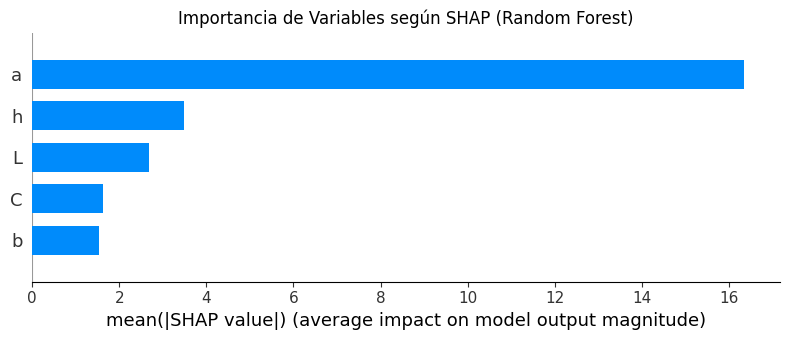

<Figure size 800x500 with 0 Axes>

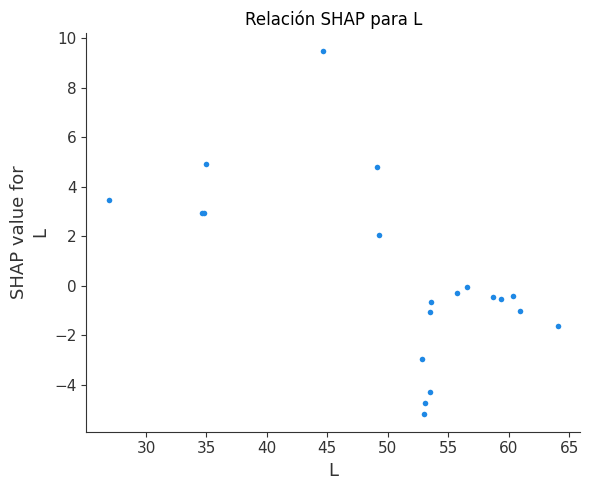

<Figure size 800x500 with 0 Axes>

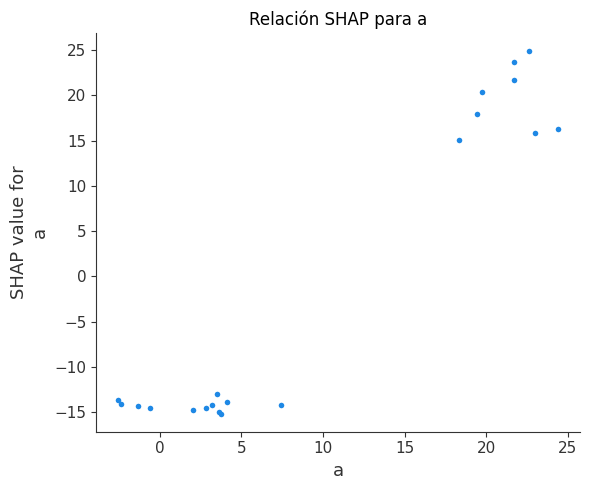

<Figure size 800x500 with 0 Axes>

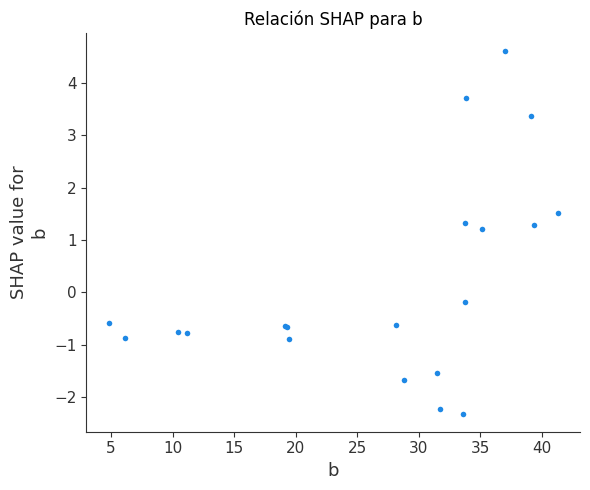

<Figure size 800x500 with 0 Axes>

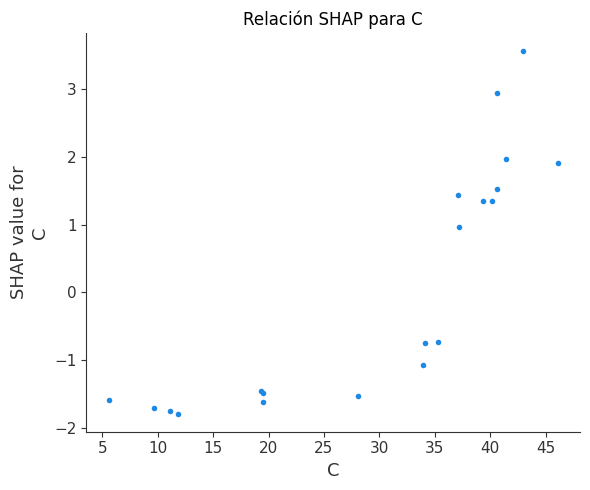

<Figure size 800x500 with 0 Axes>

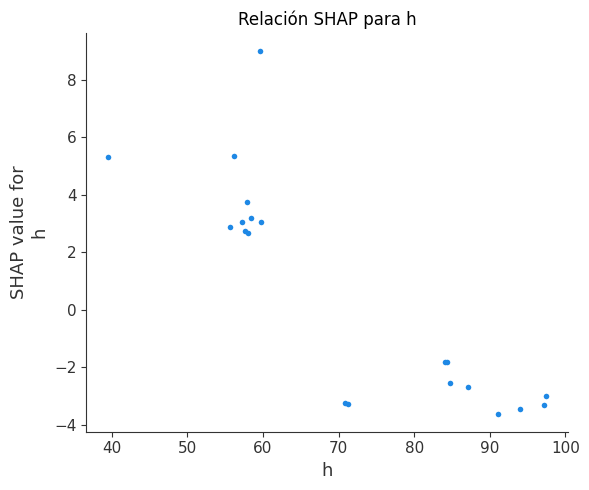

In [ ]:
import shap

# Preparar datos para SHAP
X = merged_data[['L', 'a', 'b', 'C', 'h']]
y = merged_data['ppmRefri']

# Entrenar modelo nuevamente para asegurar consistencia
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)  # Entrenar con todos los datos para mejores explicaciones

# Crear explainer SHAP
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# Gráfico de importancia global
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("Importancia de Variables según SHAP (Random Forest)")
plt.tight_layout()
plt.show()

# Gráfico de dependencia para cada variable
for feature in X.columns:
    plt.figure(figsize=(8, 5))
    shap.dependence_plot(
        feature,
        shap_values,
        X,
        interaction_index=None,
        show=False
    )
    plt.title(f"Relación SHAP para {feature}")
    plt.tight_layout()
    plt.show()

Valores máximos para normalización: b*=41.27, C=46.083425436918205

Primeras filas con el índice calculado:


,Material,b,C,ICarot_v2
0,Morada,4.83,5.592969,0.118767
1,Amarilla,39.34,39.391827,0.913858
2,6KUR,33.80,40.659562,0.844319
3,14BER,37.04,42.923393,0.911074
4,Blanca,19.33,19.496166,0.450252


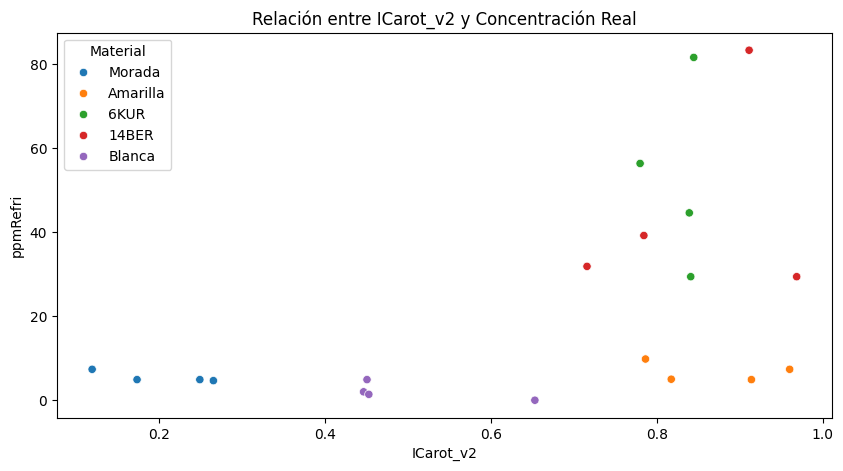

In [ ]:
# 1. Calcular máximos para normalización (usando tus datos reales)
max_b = merged_data['b'].max()  # Máximo valor de b* en tus datos
max_C = merged_data['C'].max()  # Máximo valor de Croma (C)

print(f"Valores máximos para normalización: b*={max_b}, C={max_C}")

# 2. Calcular ICarot_v2 con coeficientes ajustados
merged_data['ICarot_v2'] = (
    0.6 * (merged_data['b'] / max_b) +  # Peso 60% a b*
    0.4 * (merged_data['C'] / max_C)    # Peso 40% a Croma
)

# 3. Verificación
print("\nPrimeras filas con el índice calculado:")
display(merged_data[['Material', 'b', 'C', 'ICarot_v2']].head())

# 4. Validación visual rápida
plt.figure(figsize=(10, 5))
sns.scatterplot(data=merged_data, x='ICarot_v2', y='ppmRefri', hue='Material')
plt.title('Relación entre ICarot_v2 y Concentración Real')
plt.show()

In [ ]:
# Coeficientes ajustados basados en tus datos
coeff = {
    '6KUR': {'b': 0.5, 'C': 0.5},
    '14BER': {'b': 0.6, 'C': 0.4},
    'Amarilla': {'b': 0.7, 'C': 0.3},
    'Morada': {'b': 0.3, 'a': 0.7},  # Mayor peso a 'a*' (negativo en morados)
    'Blanca': {'b': 0.5, 'C': 0.5}
}

def calcular_indice_ajustado(row):
    material = row['Material']
    if material in coeff:
        if material == 'Morada':
            # Usamos el valor absoluto de 'a' para morados (pigmentos azules/morados)
            return (coeff[material]['b'] * (row['b']/max_b) +
                    coeff[material]['a'] * (abs(row['a'])/max_a))
        else:
            return (coeff[material]['b'] * (row['b']/max_b) +
                   coeff[material]['C'] * (row['C']/max_C))
    return np.nan

# Máximos globales para normalización
max_a = merged_data['a'].abs().max()
max_b = merged_data['b'].max()
max_C = merged_data['C'].max()

merged_data['ICarot_ajustado'] = merged_data.apply(calcular_indice_ajustado, axis=1)

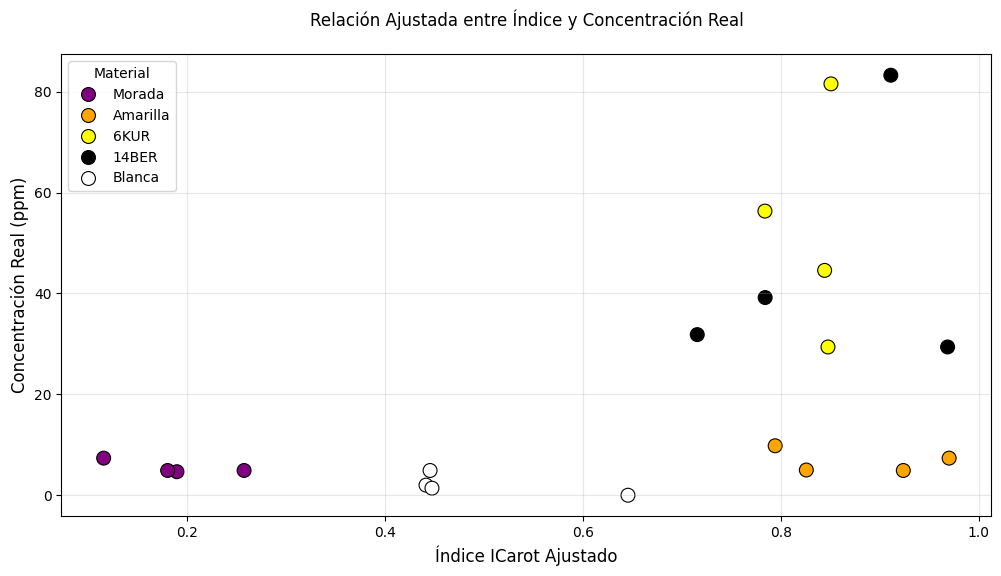

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=merged_data,
    x='ICarot_ajustado',
    y='ppmRefri',
    hue='Material',
    palette=['purple', 'orange', 'yellow', 'black', 'white'],
    edgecolor='black',
    s=100
)
plt.title('Relación Ajustada entre Índice y Concentración Real', pad=20)
plt.xlabel('Índice ICarot Ajustado', fontsize=12)
plt.ylabel('Concentración Real (ppm)', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ----------------------------------------------------------
# PASO 1: Carga y Preparación de Datos (Versión Mejorada)
# ----------------------------------------------------------

# Cargar datos
color_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Espectral/COLOR.xlsx')
conc_data = pd.read_excel('/content/drive/MyDrive/TESIS_ZANAHORIA/Espectral/Semana1_concentraciones.xlsx')

# Limpieza y normalización de columnas
color_data = color_data.rename(columns={'L*': 'L', 'a*': 'a', 'b*': 'b'})
for col in ['L', 'a', 'b']:
    color_data[col] = color_data[col].astype(str).str.replace(',', '.').astype(float)

# Calcular variables de color
color_data['C'] = np.sqrt(color_data['a']**2 + color_data['b']**2)  # Croma
color_data['h'] = np.arctan2(color_data['b'], color_data['a']) * (180/np.pi)  # Ángulo Hue

# Manejo de fechas robusto
def parse_dates(x):
    try:
        return pd.to_datetime(x, dayfirst=True) if isinstance(x, str) else pd.to_datetime(x, unit='D', origin='1899-12-30')
    except:
        return pd.NaT

color_data['Dia_muestreo'] = color_data['Dia_muestreo'].apply(parse_dates)
color_data = color_data.dropna(subset=['Dia_muestreo'])

# Unión de datos
merged_data = pd.merge(
    color_data,
    conc_data.rename(columns={'Replica': 'Repeticion'}),
    on=['Dia_muestreo', 'Material', 'Repeticion'],
    how='inner'
)

# ----------------------------------------------------------
# PASO 2: Fórmula Científica del Índice (Versión Mejorada)
# ----------------------------------------------------------

# Calcular máximos por material para normalización adaptativa
material_stats = merged_data.groupby('Material')[['a', 'b', 'C']].max()

def calcular_indice_cientifico(row):
    material = row['Material']
    max_b = material_stats.loc[material, 'b']
    max_C = material_stats.loc[material, 'C']

    if material == 'Morada':
        # Mayor peso al valor absoluto de 'a' (pigmentos morados)
        return 0.8 * (abs(row['a']) / material_stats['a'].max()) + 0.2 * (row['b'] / max_b)
    elif material == 'Blanca':
        # Mínima contribución de 'b'
        return 0.2 * (row['b'] / max_b)
    elif material in ['6KUR', '14BER']:
        # Alta contribución de 'b' y Croma
        return 0.7 * (row['b'] / max_b) + 0.3 * (row['C'] / max_C)
    else:  # Amarilla
        # Contribución balanceada pero menor que 6KUR/14BER
        return 0.5 * (row['b'] / max_b) + 0.2 * (row['C'] / max_C)

merged_data['ICarot_Cientifico'] = merged_data.apply(calcular_indice_cientifico, axis=1)

# ----------------------------------------------------------
# PASO 3: Visualización Profesional
# ----------------------------------------------------------

# Configuración estética
plt.style.use('seaborn-v0_8-whitegrid')
paleta = {
    'Morada': '#8A2BE2',
    '14BER': '#FF8C00',
    '6KUR': '#CD853F',
    'Amarilla': '#FFD700',
    'Blanca': '#F5F5F5'
}

# Gráfico de distribución del índice
plt.figure(figsize=(14, 7))
sns.boxplot(
    data=merged_data,
    x='Material',
    y='ICarot_Cientifico',
    order=['Morada', '14BER', '6KUR', 'Amarilla', 'Blanca'],
    palette=paleta,
    width=0.6,
    linewidth=2.5
)

# Añadir puntos reales
sns.stripplot(
    data=merged_data,
    x='Material',
    y='ICarot_Cientifico',
    color='black',
    alpha=0.5,
    size=6,
    jitter=True
)

# Personalización del gráfico
plt.title('Distribución del Índice de Carotenoides por Variedad', fontsize=16, pad=20)
plt.xlabel('Variedad', fontsize=14)
plt.ylabel('Valor del Índice', fontsize=14)
plt.ylim(0, 1.1)
plt.xticks(fontsize=12, rotation=45)
plt.grid(axis='y', alpha=0.3)

# Añadir anotaciones clave
plt.annotate('Morada > Blanca', xy=(0, 1.05), xytext=(0.5, 1.1),
             ha='center', fontsize=12, color='#8A2BE2', weight='bold',
             arrowprops=dict(arrowstyle='->', color='#8A2BE2'))

plt.annotate('Amarilla < 14BER/6KUR', xy=(3, 0.4), xytext=(3, 0.3),
             ha='center', fontsize=12, color='#FF8C00',
             arrowprops=dict(arrowstyle='->', color='#FF8C00'))

plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# PASO 4: Validación Estadística
# ----------------------------------------------------------

# 1. Correlación global
corr, pval = spearmanr(merged_data['ICarot_Cientifico'], merged_data['ppmRefri'])
print(f"Correlación Spearman Global: {corr:.3f} (p-value: {pval:.4f})")

# 2. Correlación por material
print("\nCorrelación por Material:")
for material in merged_data['Material'].unique():
    subset = merged_data[merged_data['Material'] == material]
    corr_material = spearmanr(subset['ICarot_Cientifico'], subset['ppmRefri']).correlation
    print(f"- {material}: {corr_material:.3f}")

# 3. Tabla comparativa
print("\nComparación de Medianas:")
comparacion = merged_data.groupby('Material').agg({
    'ICarot_Cientifico': 'median',
    'ppmRefri': 'median'
}).sort_values('ICarot_Cientifico', ascending=False)
print(comparacion)

# 4. Gráfico de correlación
plt.figure(figsize=(10, 6))
sns.lmplot(
    data=merged_data,
    x='ICarot_Cientifico',
    y='ppmRefri',
    hue='Material',
    palette=paleta,
    height=6,
    aspect=1.5
)
plt.title('Relación entre Índice y Concentración Real', fontsize=14)
plt.xlabel('Índice ICarot Científico')
plt.ylabel('Concentración (ppm)')
plt.show()

ValueError: Cannot set a DataFrame with multiple columns to the single column ICarot_Cientifico

Pesos derivados de correlación con ppmRefri:
a           0.285911
b           0.140927
C           0.216394
ppmRefri    0.356768
Name: ppmRefri, dtype: float64


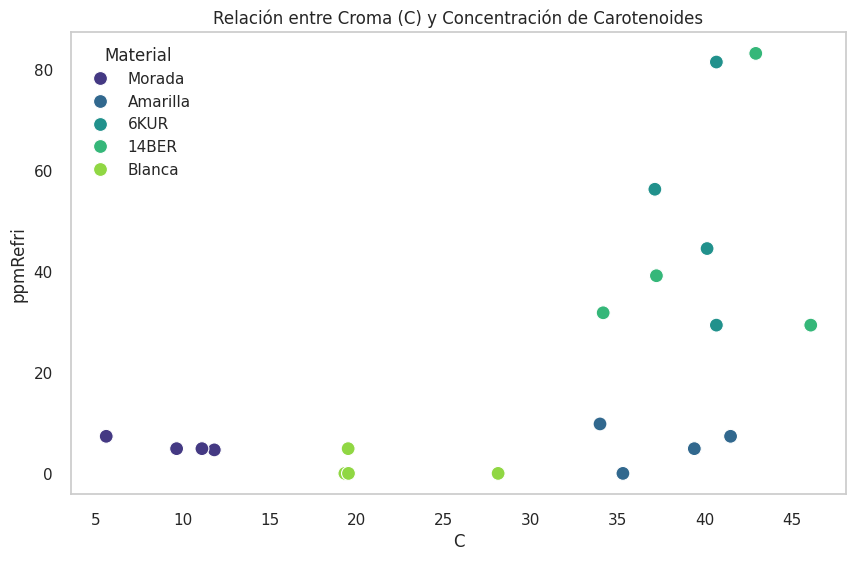

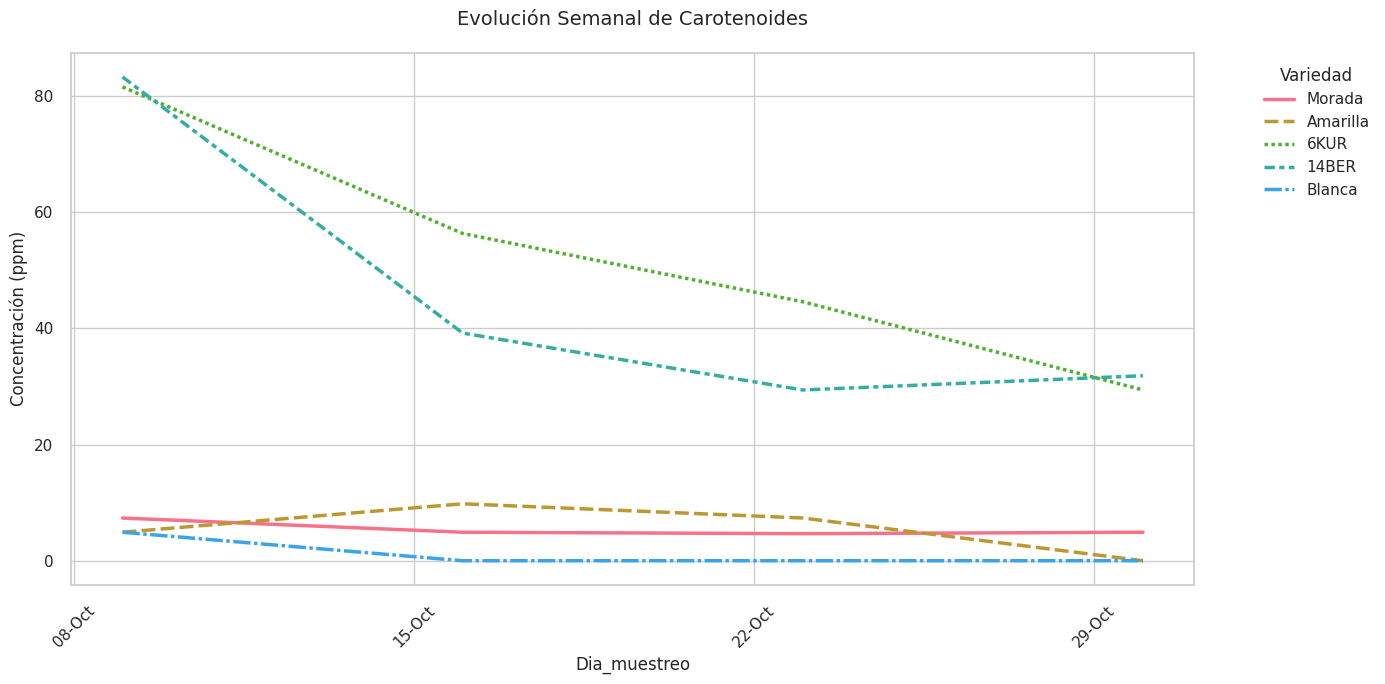

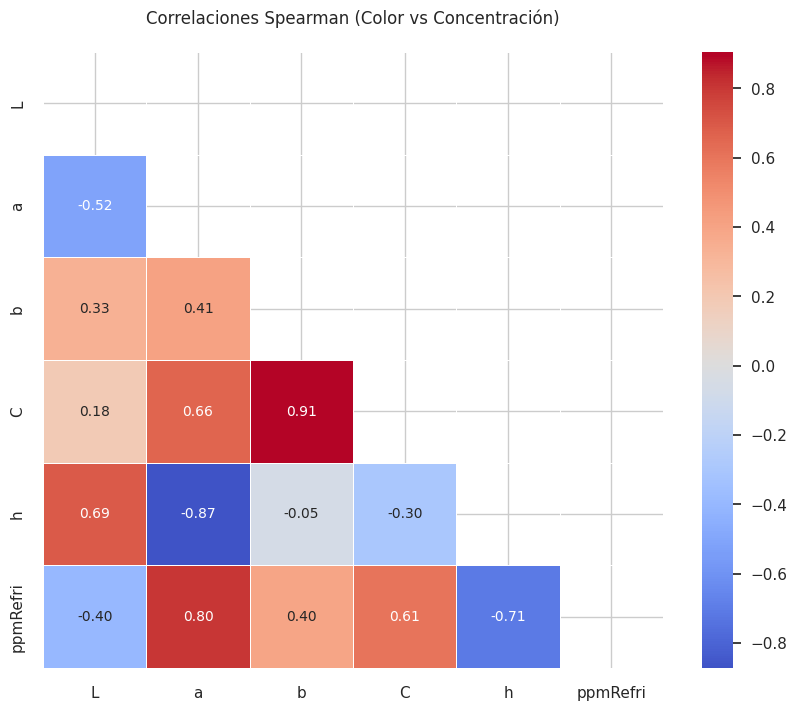

R² Entrenamiento: 0.934
R² Prueba: -0.299


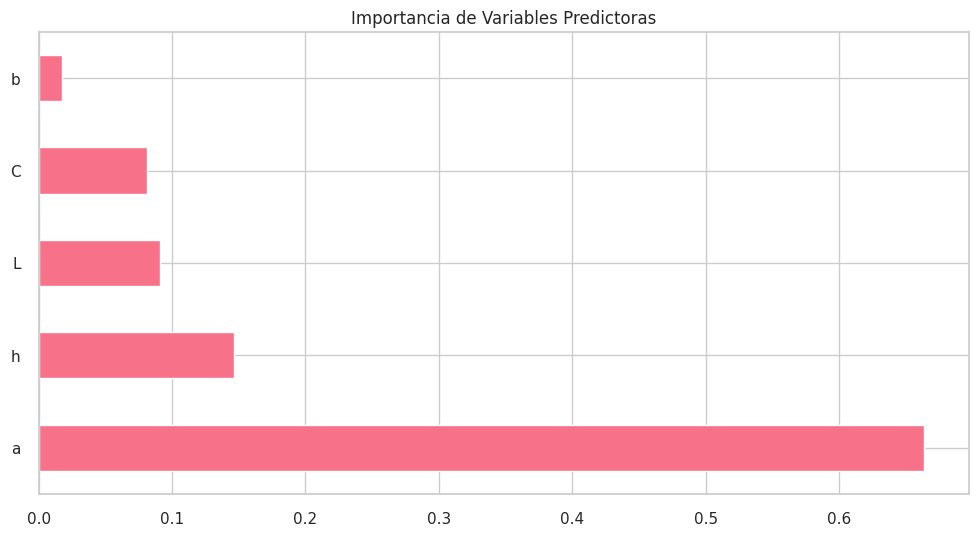

/tmp/ipython-input-1115998708.py:159: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


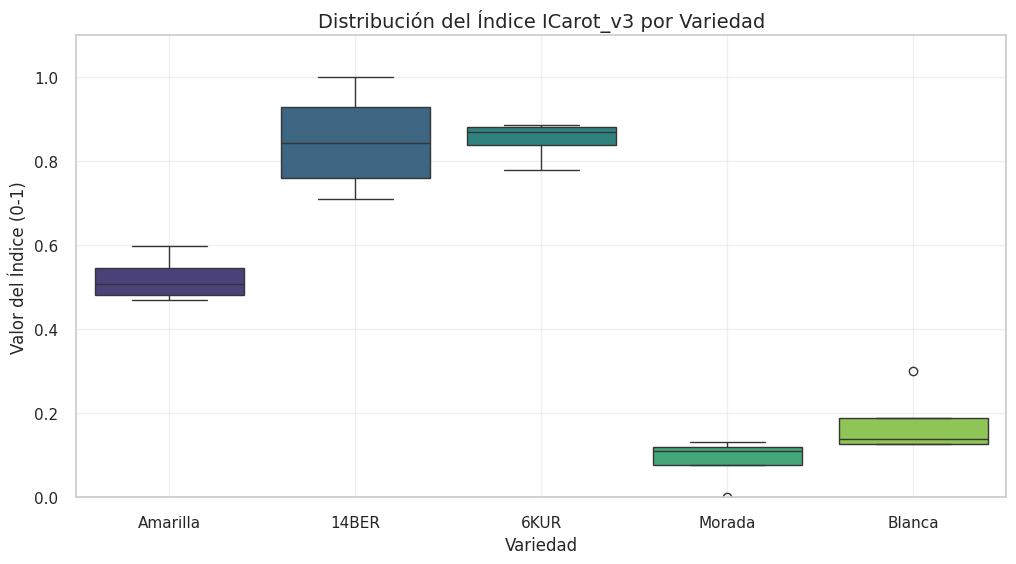

    Material      a      b          C  ICarot_v3 Categoria   ppmRefri
13     14BER  24.39  39.10  46.083425   1.000000      Alto  29.397283
3      14BER  21.69  37.04  42.923393   0.907393      Alto  83.280156
17      6KUR  22.97  33.55  40.659850   0.886622      Alto  29.397283
2       6KUR  22.60  33.80  40.659562   0.881495      Alto  81.565701
12      6KUR  21.70  33.75  40.124213   0.859677      Alto  44.582456
7       6KUR  19.71  31.46  37.124328   0.780055     Medio  56.338719
8      14BER  19.46  31.72  37.213573   0.778027     Medio  39.194169
18     14BER  18.31  28.83  34.152965   0.709260     Medio  31.846504
11  Amarilla   4.11  41.27  41.474149   0.599348     Medio   7.354289
1   Amarilla   2.02  39.34  39.391827   0.528783     Medio   4.905068
16  Amarilla   3.24  35.14  35.289052   0.485150     Medio   0.000000
6   Amarilla   3.51  33.79  33.971815   0.468895     Medio   9.803511
19    Blanca  -0.56  28.11  28.115578   0.301965     Medio   0.000000
14    Blanca  -1.34 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# === 1. Cargar datos ===
color_path = '/content/drive/MyDrive/Colab Notebooks/Espectral/COLOR.xlsx'
conc_path = '/content/drive/MyDrive/TESIS_ZANAHORIA/Espectral/Semana1_concentraciones.csv'

color_data = pd.read_excel(color_path)
conc_data = pd.read_csv(conc_path)

# === 2. Renombrar columnas de color ===
color_data = color_data.rename(columns={'L*': 'L', 'a*': 'a', 'b*': 'b'})

# === 3. Convertir L, a, b a numéricos (manejo de comas) ===
color_data['L'] = color_data['L'].astype(str).str.replace(',', '.').astype(float)
color_data['a'] = color_data['a'].astype(str).str.replace(',', '.').astype(float)
color_data['b'] = color_data['b'].astype(str).str.replace(',', '.').astype(float)

# === 4. Calcular Croma y Hue ===
color_data['C'] = np.sqrt(color_data['a']**2 + color_data['b']**2)
color_data['h'] = np.arctan2(color_data['b'], color_data['a']) * (180 / np.pi)

# === 5. Ajustar nombre de columnas en concentraciones ===
conc_data = conc_data.rename(columns={'Replica': 'Repeticion'})

# === 6. Conversión de fechas ===
def convertir_fecha(x):
    try:
        return pd.to_datetime(x, dayfirst=True)
    except:
        try:
            return pd.to_datetime(float(x), unit='D', origin='1899-12-30')
        except:
            return pd.NaT

color_data['Dia_muestreo'] = color_data['Dia_muestreo'].apply(convertir_fecha)
conc_data['Dia_muestreo'] = conc_data['Dia_muestreo'].apply(convertir_fecha)

color_data = color_data.dropna(subset=['Dia_muestreo'])
conc_data = conc_data.dropna(subset=['Dia_muestreo'])

# === 7. Unir DataFrames ===
merged_data = pd.merge(
    color_data,
    conc_data,
    on=['Dia_muestreo', 'Material', 'Repeticion'],
    how='inner'
)

# === 8. Índices adicionales ===
merged_data['YI'] = (142.86 * merged_data['b']) / merged_data['L']  # Amarillez
merged_data['h°'] = np.arctan2(merged_data['b'], merged_data['a']) * (180/np.pi)

# === 9. Correlación Spearman ===
corr_spearman = merged_data[['a', 'b', 'C', 'ppmRefri']].corr(method='spearman')['ppmRefri']
pesos = corr_spearman / corr_spearman.sum()

print("Pesos derivados de correlación con ppmRefri:")
print(pesos)

# === 10. Normalización robusta MinMax ===
scaler = MinMaxScaler()
merged_data[['a_norm', 'b_norm', 'C_norm']] = scaler.fit_transform(
    merged_data[['a', 'b', 'C']]
)

# === 11. Calcular ICarot_v3 con pesos automáticos ===
merged_data['ICarot_v3'] = (
    pesos['b'] * merged_data['b_norm'] +
    pesos['a'] * merged_data['a_norm'] +
    pesos['C'] * merged_data['C_norm']
)

# Escalar 0-1
merged_data['ICarot_v3'] = (merged_data['ICarot_v3'] - merged_data['ICarot_v3'].min()) / \
                           (merged_data['ICarot_v3'].max() - merged_data['ICarot_v3'].min())

# === 12. Categorías por percentiles ===
merged_data['Categoria'] = pd.qcut(
    merged_data['ICarot_v3'],
    q=[0, 0.25, 0.75, 1],
    labels=['Bajo', 'Medio', 'Alto']
)

# === 13. Gráfico Croma vs ppmRefri ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_data,
    x='C',
    y='ppmRefri',
    hue='Material',
    palette='viridis',
    s=100
)
plt.title('Relación entre Croma (C) y Concentración de Carotenoides')
plt.grid()
plt.show()

# === 14. Evolución semanal ===
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=merged_data,
    x='Dia_muestreo',
    y='ppmRefri',
    hue='Material',
    style='Material',
    markersize=10,
    linewidth=2.5
)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.title('Evolución Semanal de Carotenoides', pad=20, fontsize=14)
plt.ylabel('Concentración (ppm)', fontsize=12)
plt.legend(title='Variedad', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === 15. Correlaciones ===
corr_matrix = merged_data[['L', 'a', 'b', 'C', 'h', 'ppmRefri']].corr(method='spearman')
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    linewidths=.5,
    annot_kws={"size": 10}
)
plt.title('Correlaciones Spearman (Color vs Concentración)', pad=20)
plt.show()

# === 16. Random Forest ===
X = merged_data[['L', 'a', 'b', 'C', 'h']]
y = merged_data['ppmRefri']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print(f"R² Entrenamiento: {rf.score(X_train, y_train):.3f}")
print(f"R² Prueba: {rf.score(X_test, y_test):.3f}")

# Importancia de variables
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title('Importancia de Variables Predictoras')
plt.show()

# === 17. Distribución del índice ===
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_data,
    x='Material',
    y='ICarot_v3',
    palette='viridis',
    order=['Amarilla', '14BER', '6KUR', 'Morada', 'Blanca']  # Orden esperado
)
plt.title('Distribución del Índice ICarot_v3 por Variedad', fontsize=14)
plt.xlabel('Variedad', fontsize=12)
plt.ylabel('Valor del Índice (0-1)', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(alpha=0.3)
plt.show()

# === 18. Vista previa final ===
print(merged_data[['Material', 'a', 'b', 'C', 'ICarot_v3', 'Categoria', 'ppmRefri']].sort_values('ICarot_v3', ascending=False))


In [ ]:
from scipy.stats import spearmanr, pearsonr, kendalltau
rho, _ = spearmanr(merged_data['ICarot_v3'], merged_data['ppmRefri'])
r, _ = pearsonr(merged_data['ICarot_v3'], merged_data['ppmRefri'])
tau, _ = kendalltau(merged_data['ICarot_v3'], merged_data['ppmRefri'])
print(f"Spearman: {rho:.3f}, Pearson: {r:.3f}, Kendall: {tau:.3f}")


Spearman: 0.734, Pearson: 0.766, Kendall: 0.536


/tmp/ipython-input-3484157874.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x='Métrica', y='Valor', palette='viridis')


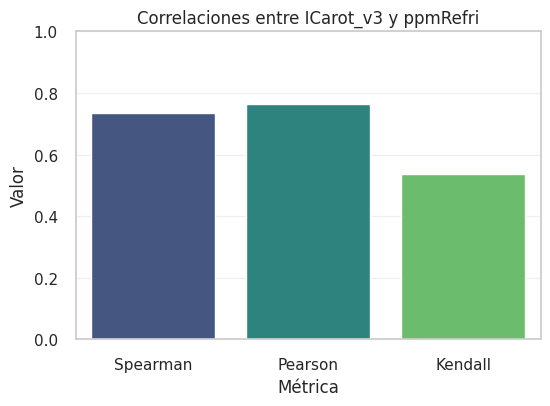

/tmp/ipython-input-3484157874.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=error_df, x='Métrica', y='Valor', palette='magma')


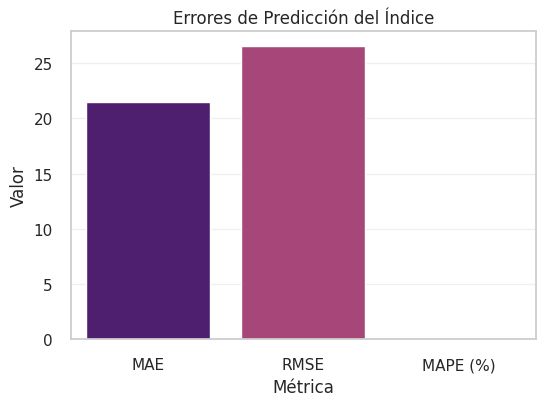

Accuracy: 0.50, Kappa: 0.20, F1: 0.50


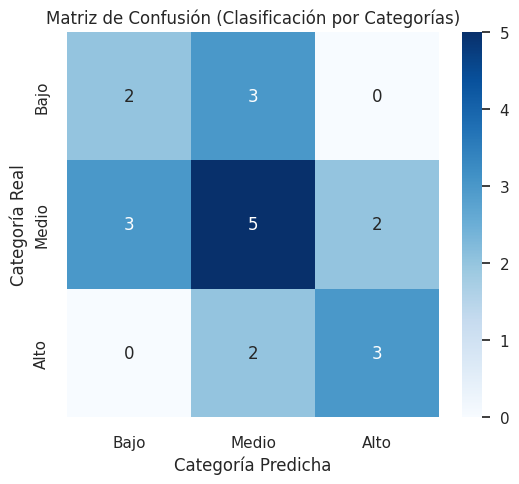

In [ ]:
from scipy.stats import spearmanr, pearsonr, kendalltau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, accuracy_score, cohen_kappa_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ===== 1. Correlaciones =====
rho, _ = spearmanr(merged_data['ICarot_v3'], merged_data['ppmRefri'])
r, _ = pearsonr(merged_data['ICarot_v3'], merged_data['ppmRefri'])
tau, _ = kendalltau(merged_data['ICarot_v3'], merged_data['ppmRefri'])

corr_df = pd.DataFrame({
    'Métrica': ['Spearman', 'Pearson', 'Kendall'],
    'Valor': [rho, r, tau]
})

plt.figure(figsize=(6,4))
sns.barplot(data=corr_df, x='Métrica', y='Valor', palette='viridis')
plt.ylim(0, 1)
plt.title('Correlaciones entre ICarot_v3 y ppmRefri')
plt.grid(axis='y', alpha=0.3)
plt.show()

# ===== 2. Errores =====
y_true = merged_data['ppmRefri']
y_pred = merged_data['ICarot_v3'] * y_true.max()  # Escalar índice al rango de ppm

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # Versión compatible
mape = (abs((y_true - y_pred) / y_true).mean()) * 100

error_df = pd.DataFrame({
    'Métrica': ['MAE', 'RMSE', 'MAPE (%)'],
    'Valor': [mae, rmse, mape]
})

plt.figure(figsize=(6,4))
sns.barplot(data=error_df, x='Métrica', y='Valor', palette='magma')
plt.title('Errores de Predicción del Índice')
plt.grid(axis='y', alpha=0.3)
plt.show()

# ===== 3. Clasificación y matriz de confusión =====
# Categorías reales basadas en percentiles de ppmRefri
real_cat = pd.qcut(y_true, q=[0, 0.25, 0.75, 1], labels=['Bajo', 'Medio', 'Alto'])
pred_cat = merged_data['Categoria']

acc = accuracy_score(real_cat, pred_cat)
kappa = cohen_kappa_score(real_cat, pred_cat)
f1 = f1_score(real_cat, pred_cat, average='macro')

print(f"Accuracy: {acc:.2f}, Kappa: {kappa:.2f}, F1: {f1:.2f}")

cm = confusion_matrix(real_cat, pred_cat, labels=['Bajo', 'Medio', 'Alto'])
cm_df = pd.DataFrame(cm, index=['Bajo', 'Medio', 'Alto'], columns=['Bajo', 'Medio', 'Alto'])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión (Clasificación por Categorías)')
plt.ylabel('Categoría Real')
plt.xlabel('Categoría Predicha')
plt.show()


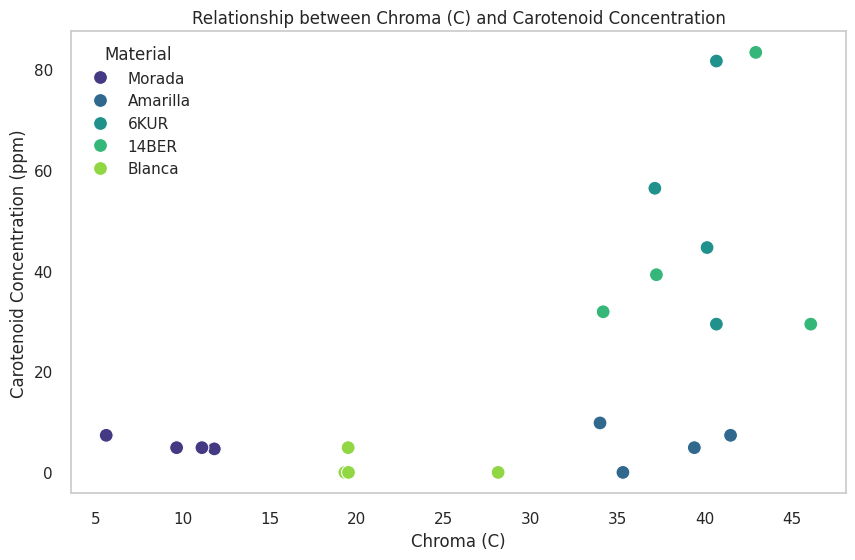

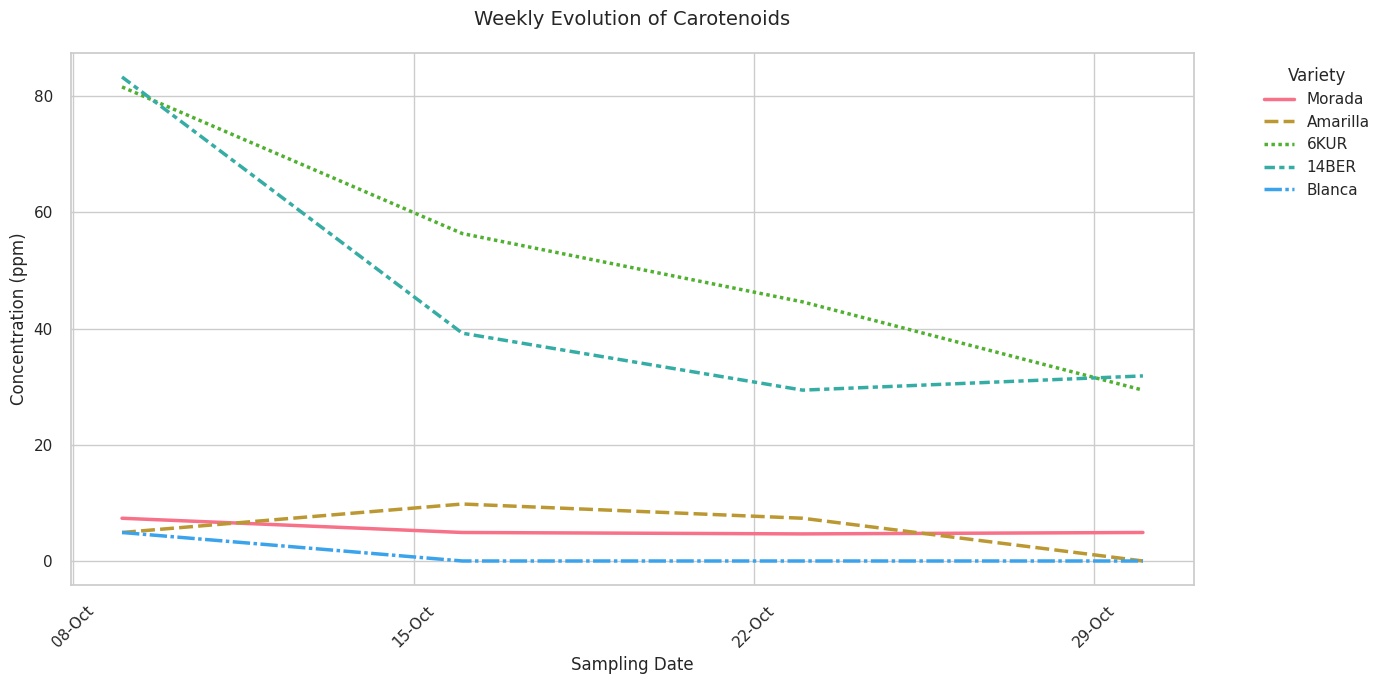

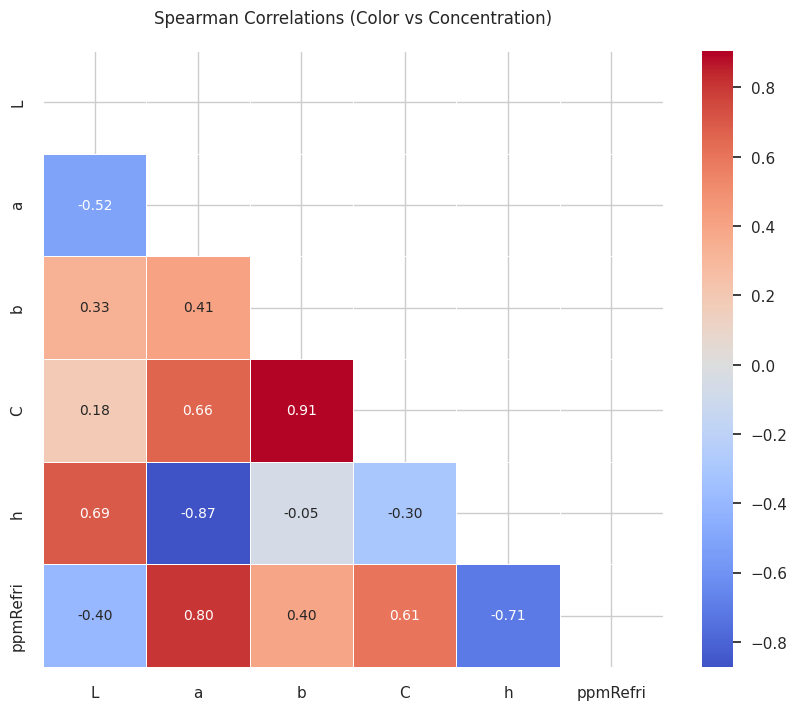

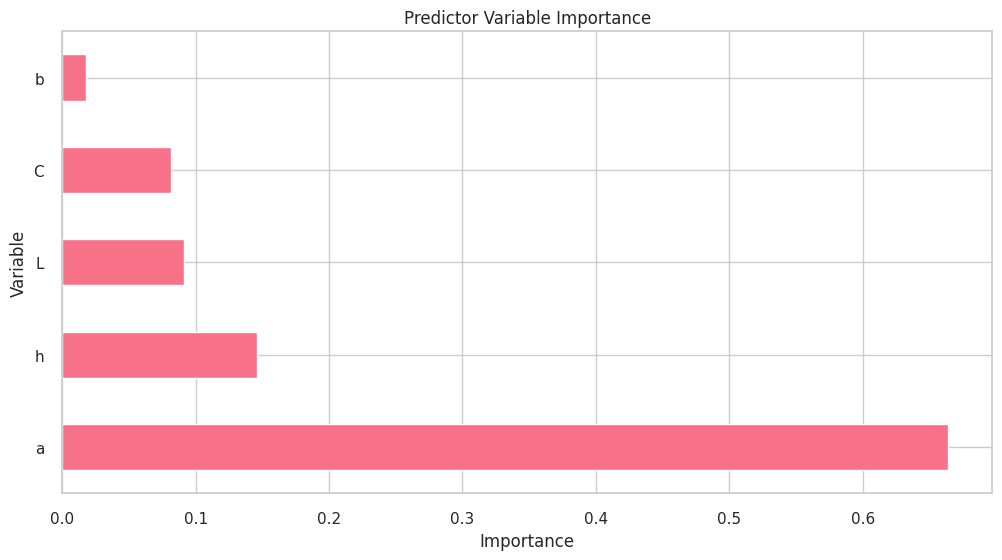

/tmp/ipython-input-542224584.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


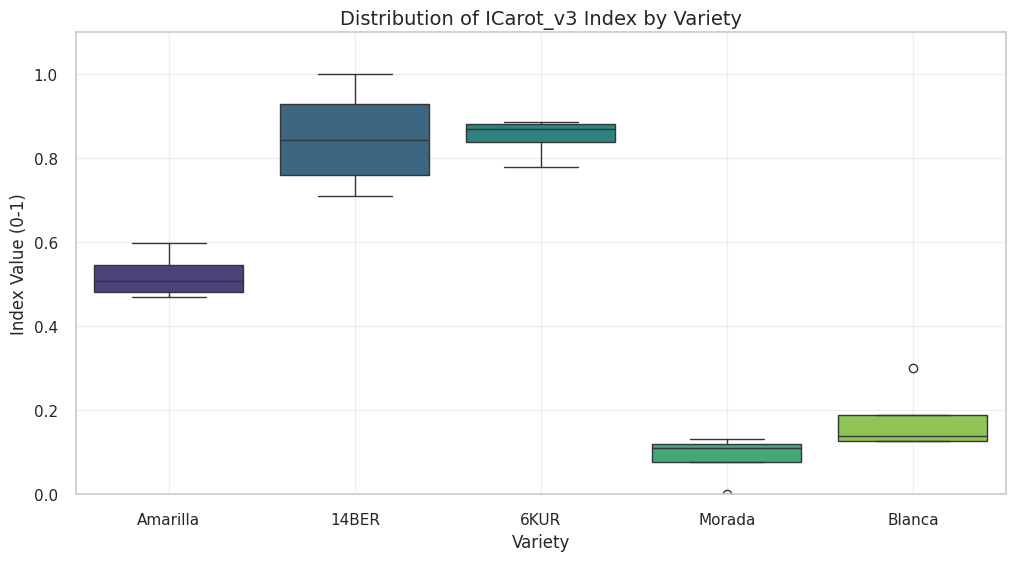

In [ ]:
# === 13. Chromaticity (C) vs Carotenoid concentration ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_data,
    x='C',
    y='ppmRefri',
    hue='Material',
    palette='viridis',
    s=100
)
plt.title('Relationship between Chroma (C) and Carotenoid Concentration')
plt.xlabel('Chroma (C)')
plt.ylabel('Carotenoid Concentration (ppm)')
plt.grid()
plt.show()

# === 14. Weekly evolution ===
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=merged_data,
    x='Dia_muestreo',
    y='ppmRefri',
    hue='Material',
    style='Material',
    markersize=10,
    linewidth=2.5
)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.title('Weekly Evolution of Carotenoids', pad=20, fontsize=14)
plt.xlabel('Sampling Date')
plt.ylabel('Concentration (ppm)', fontsize=12)
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === 15. Correlations ===
corr_matrix = merged_data[['L', 'a', 'b', 'C', 'h', 'ppmRefri']].corr(method='spearman')
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    linewidths=.5,
    annot_kws={"size": 10}
)
plt.title('Spearman Correlations (Color vs Concentration)', pad=20)
plt.show()

# === 16. Random Forest variable importance ===
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title('Predictor Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.show()

# === 17. Distribution of the index ===
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_data,
    x='Material',
    y='ICarot_v3',
    palette='viridis',
    order=['Amarilla', '14BER', '6KUR', 'Morada', 'Blanca']
)
plt.title('Distribution of ICarot_v3 Index by Variety', fontsize=14)
plt.xlabel('Variety', fontsize=12)
plt.ylabel('Index Value (0-1)', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(alpha=0.3)
plt.show()


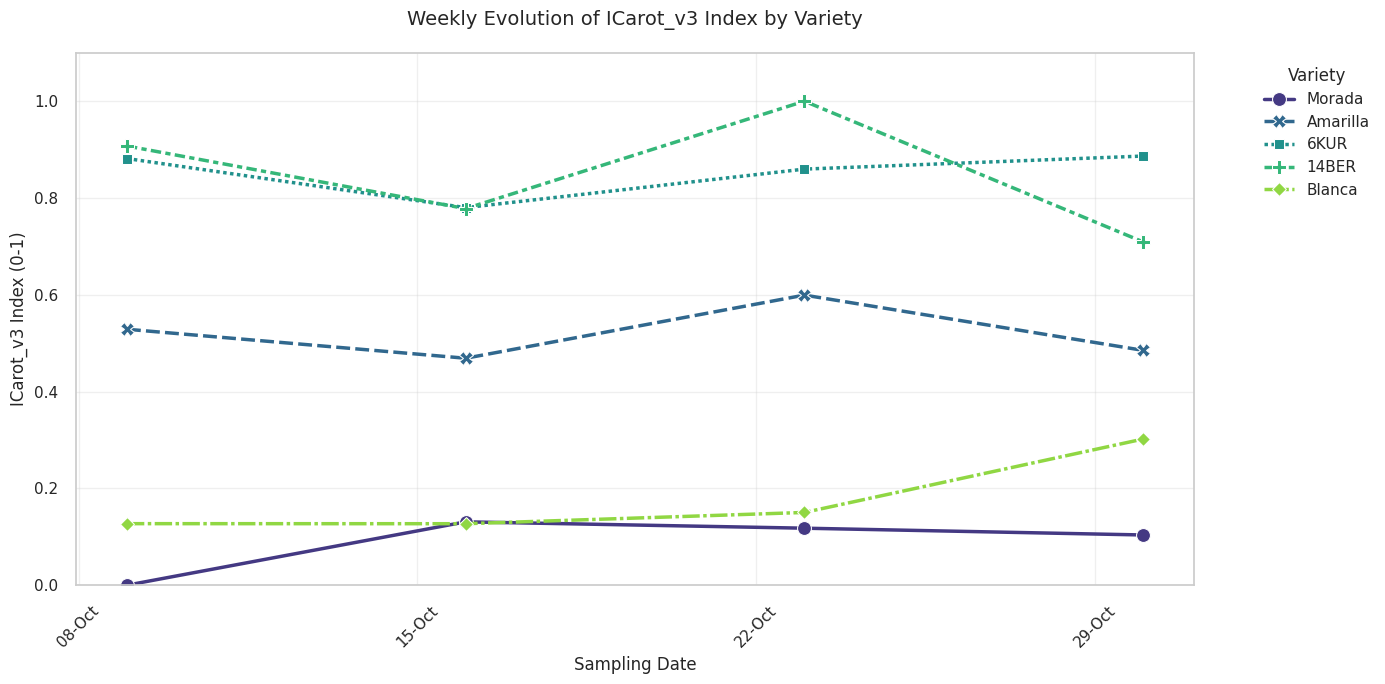

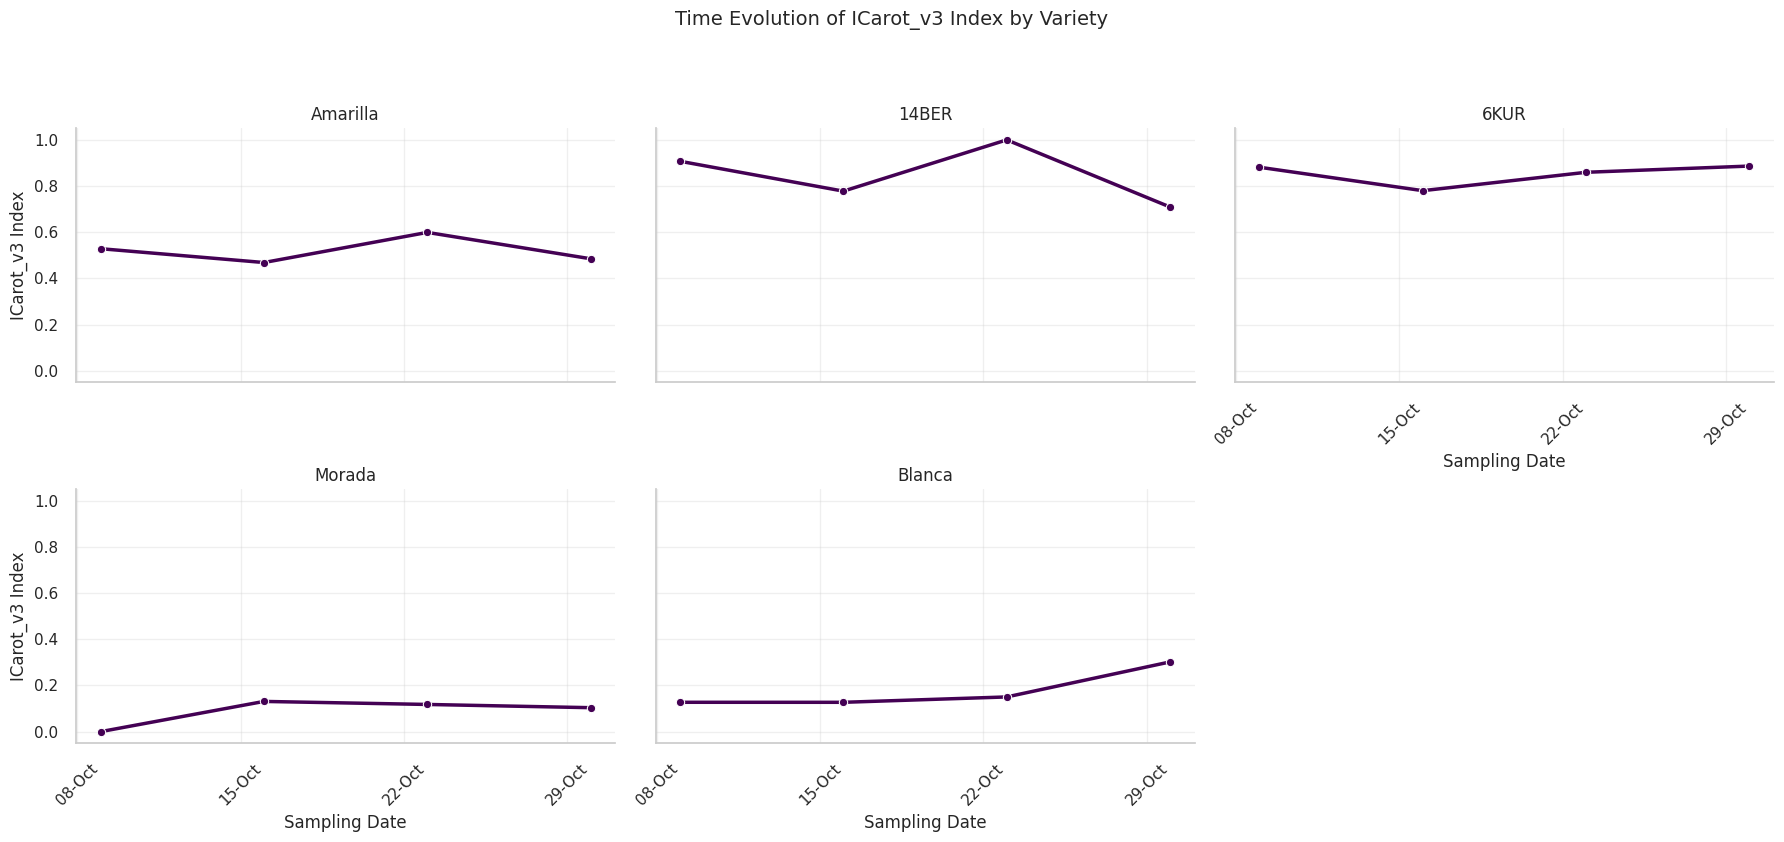

In [ ]:
# === 18. Time Evolution of ICarot_v3 Index ===
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=merged_data,
    x='Dia_muestreo',
    y='ICarot_v3',
    hue='Material',
    style='Material',
    markers=True,
    markersize=10,
    linewidth=2.5,
    palette='viridis'
)

# Format x-axis as dates
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)

# Add labels and title
plt.title('Weekly Evolution of ICarot_v3 Index by Variety', fontsize=14, pad=20)
plt.xlabel('Sampling Date', fontsize=12)
plt.ylabel('ICarot_v3 Index (0-1)', fontsize=12)
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid and adjust layout
plt.grid(alpha=0.3)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# === 19. Faceted Plot by Variety ===
g = sns.FacetGrid(
    data=merged_data,
    col='Material',
    col_order=['Amarilla', '14BER', '6KUR', 'Morada', 'Blanca'],
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=True
)
g.map_dataframe(
    sns.lineplot,
    x='Dia_muestreo',
    y='ICarot_v3',
    marker='o',
    linewidth=2.5,
    color='#440154'  # Dark purple from viridis
)

# Format x-axis for each subplot
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)

# Add titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Sampling Date', 'ICarot_v3 Index')
g.fig.suptitle('Time Evolution of ICarot_v3 Index by Variety', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

Weights derived from Spearman correlation with ppmRefri:
a           0.285911
b           0.140927
C           0.216394
ppmRefri    0.356768
Name: ppmRefri, dtype: float64


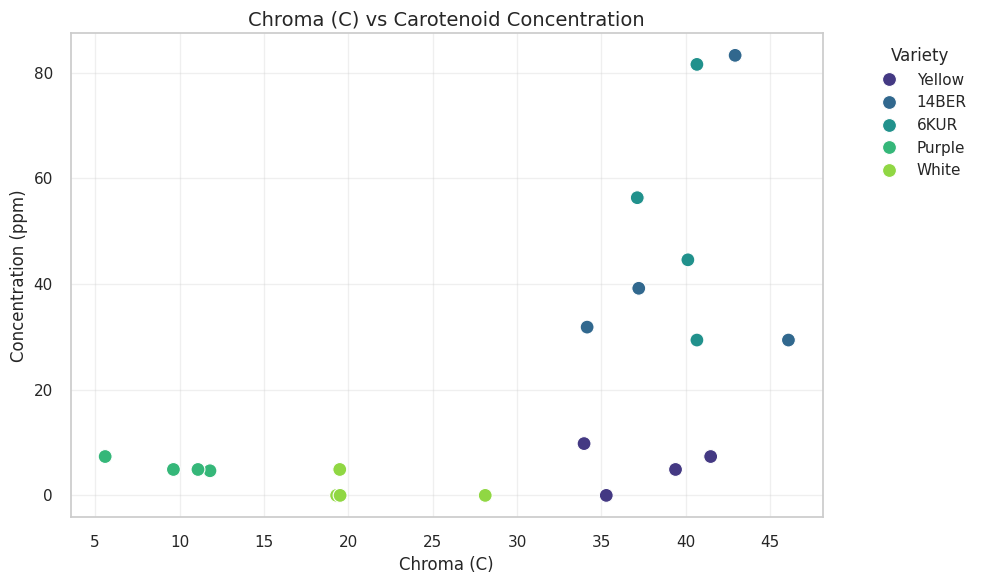

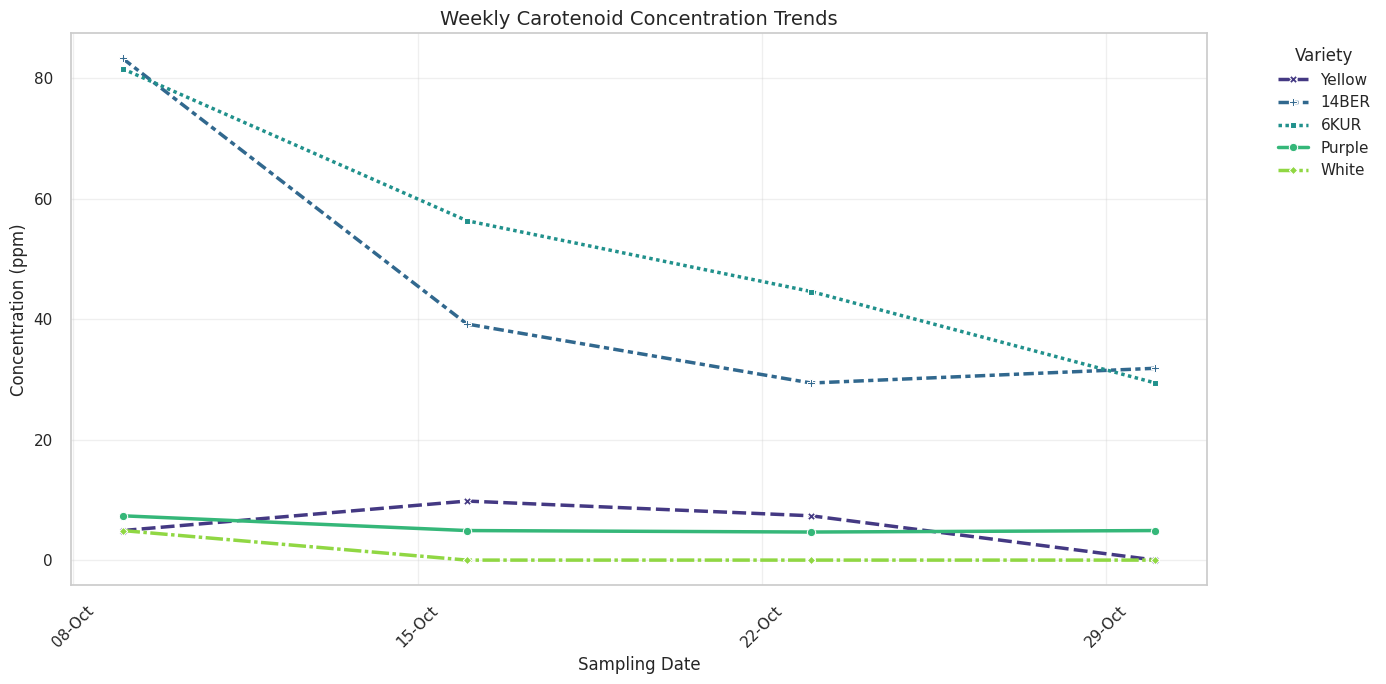

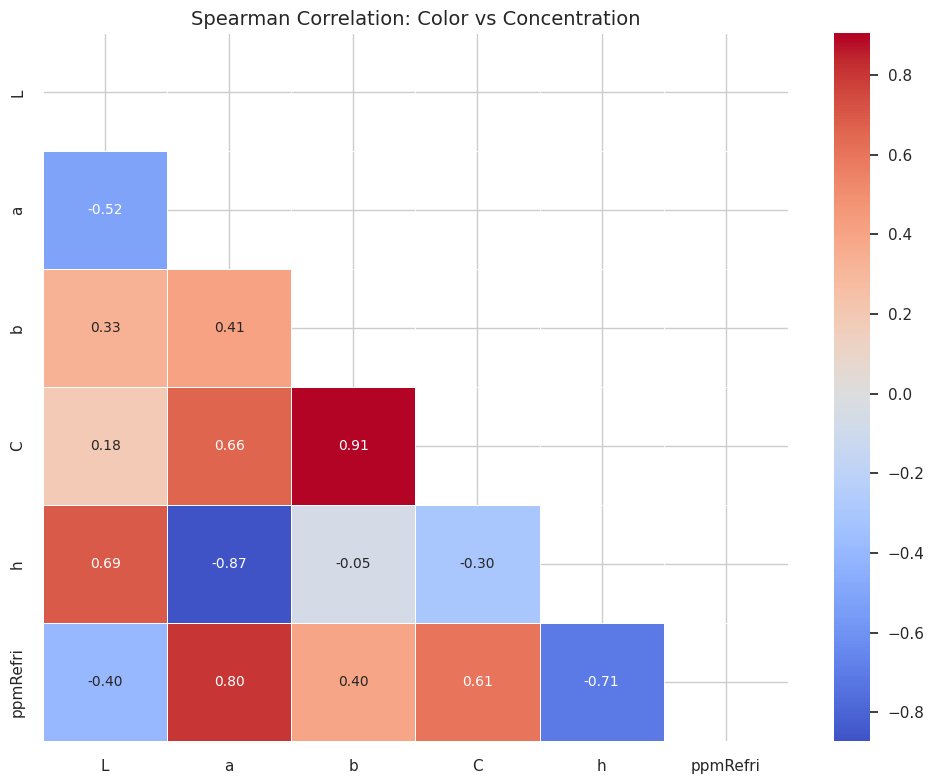

Training R²: 0.934
Test R²: -0.299


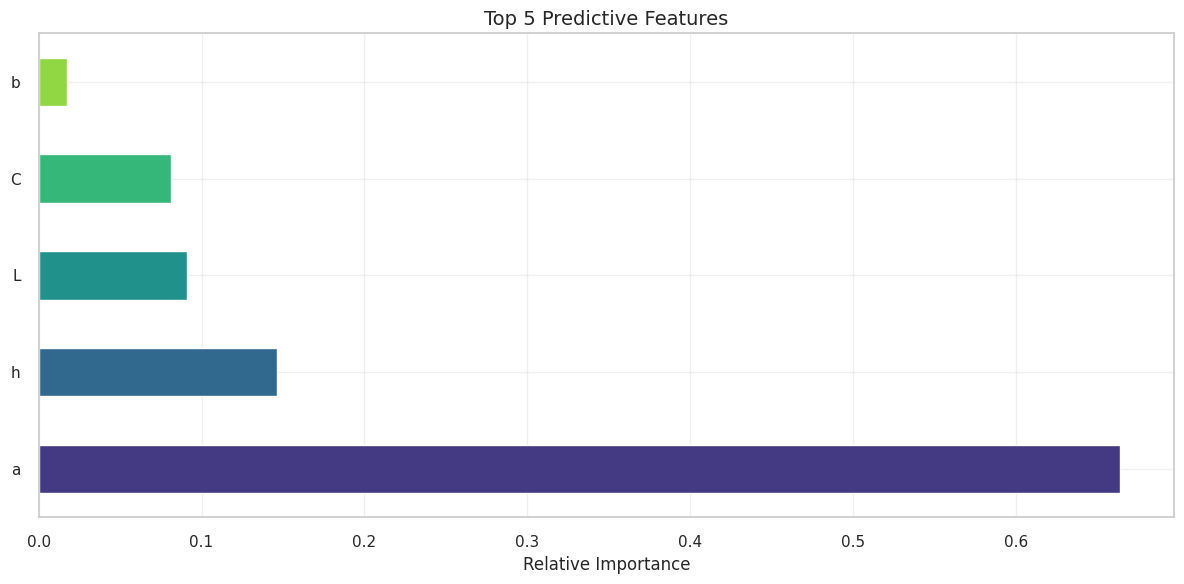

/tmp/ipython-input-2650398216.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


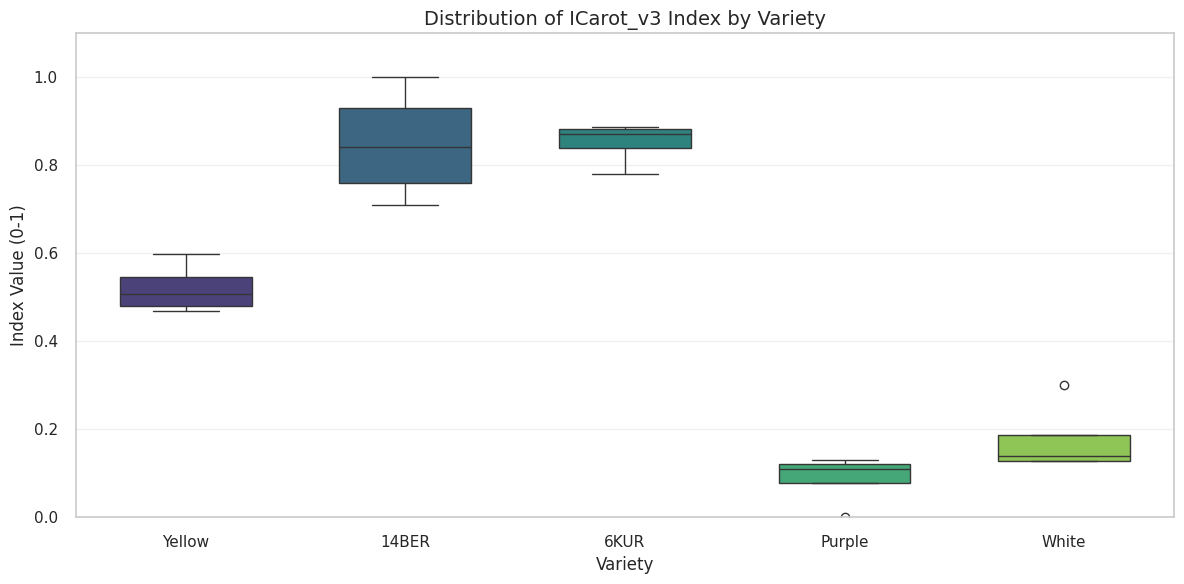

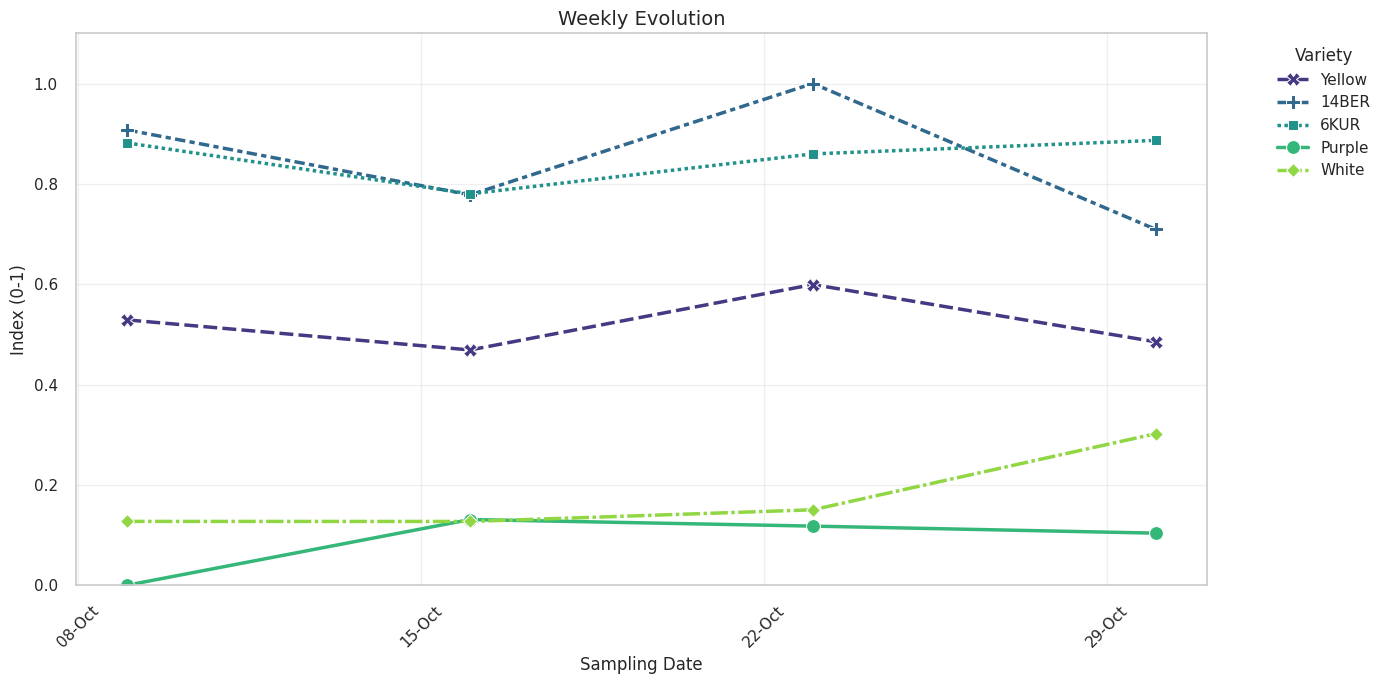

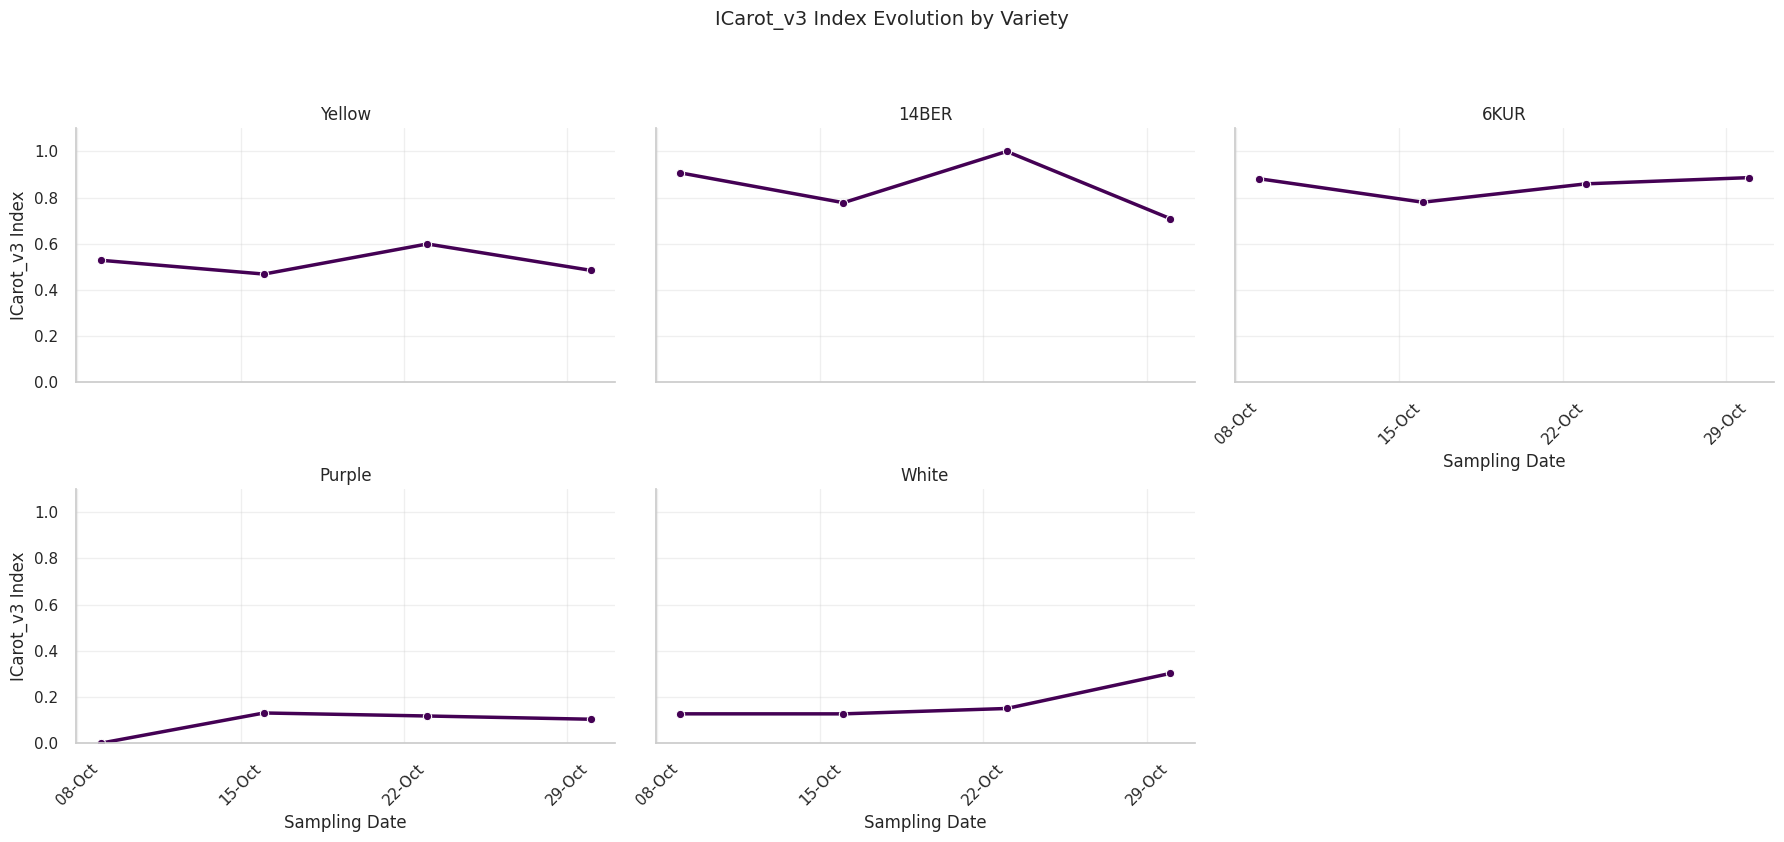

   Variety      a      b          C  ICarot_v3 Category   ppmRefri
13   14BER  24.39  39.10  46.083425   1.000000     High  29.397283
3    14BER  21.69  37.04  42.923393   0.907393     High  83.280156
17    6KUR  22.97  33.55  40.659850   0.886622     High  29.397283
2     6KUR  22.60  33.80  40.659562   0.881495     High  81.565701
12    6KUR  21.70  33.75  40.124213   0.859677     High  44.582456
7     6KUR  19.71  31.46  37.124328   0.780055   Medium  56.338719
8    14BER  19.46  31.72  37.213573   0.778027   Medium  39.194169
18   14BER  18.31  28.83  34.152965   0.709260   Medium  31.846504
11  Yellow   4.11  41.27  41.474149   0.599348   Medium   7.354289
1   Yellow   2.02  39.34  39.391827   0.528783   Medium   4.905068


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# === 1. Load data ===
color_path = '/content/drive/MyDrive/Colab Notebooks/Espectral/COLOR.xlsx'
conc_path = '/content/drive/MyDrive/TESIS_ZANAHORIA/Espectral/Semana1_concentraciones.csv'

color_data = pd.read_excel(color_path)
conc_data = pd.read_csv(conc_path)

# === 2. Rename color columns ===
color_data = color_data.rename(columns={'L*': 'L', 'a*': 'a', 'b*': 'b'})

# === 3. Convert L, a, b to numeric (handle commas) ===
color_data['L'] = color_data['L'].astype(str).str.replace(',', '.').astype(float)
color_data['a'] = color_data['a'].astype(str).str.replace(',', '.').astype(float)
color_data['b'] = color_data['b'].astype(str).str.replace(',', '.').astype(float)

# === 4. Calculate Chroma and Hue ===
color_data['C'] = np.sqrt(color_data['a']**2 + color_data['b']**2)
color_data['h'] = np.arctan2(color_data['b'], color_data['a']) * (180 / np.pi)

# === 5. Adjust column names in concentrations ===
conc_data = conc_data.rename(columns={'Replica': 'Repeticion'})

# === 6. Date conversion ===
def convertir_fecha(x):
    try:
        return pd.to_datetime(x, dayfirst=True)
    except:
        try:
            return pd.to_datetime(float(x), unit='D', origin='1899-12-30')
        except:
            return pd.NaT

color_data['Dia_muestreo'] = color_data['Dia_muestreo'].apply(convertir_fecha)
conc_data['Dia_muestreo'] = conc_data['Dia_muestreo'].apply(convertir_fecha)

color_data = color_data.dropna(subset=['Dia_muestreo'])
conc_data = conc_data.dropna(subset=['Dia_muestreo'])

# === 7. Merge DataFrames ===
merged_data = pd.merge(
    color_data,
    conc_data,
    on=['Dia_muestreo', 'Material', 'Repeticion'],
    how='inner'
)

# === 8. Translate variety names ===
variety_names = {
    'Amarilla': 'Yellow',
    '14BER': '14BER',
    '6KUR': '6KUR',
    'Morada': 'Purple',  # This will appear before White in legends
    'Blanca': 'White'
}
merged_data['Variety'] = merged_data['Material'].map(variety_names)
variety_order = ['Yellow', '14BER', '6KUR', 'Purple', 'White']

# === 9. Additional indices ===
merged_data['YI'] = (142.86 * merged_data['b']) / merged_data['L']  # Yellowness
merged_data['h°'] = np.arctan2(merged_data['b'], merged_data['a']) * (180/np.pi)

# === 10. Spearman Correlation ===
corr_spearman = merged_data[['a', 'b', 'C', 'ppmRefri']].corr(method='spearman')['ppmRefri']
pesos = corr_spearman / corr_spearman.sum()

print("Weights derived from Spearman correlation with ppmRefri:")
print(pesos)

# === 11. MinMax Robust Normalization ===
scaler = MinMaxScaler()
merged_data[['a_norm', 'b_norm', 'C_norm']] = scaler.fit_transform(
    merged_data[['a', 'b', 'C']]
)

# === 12. Calculate ICarot_v3 with automatic weights ===
merged_data['ICarot_v3'] = (
    pesos['b'] * merged_data['b_norm'] +
    pesos['a'] * merged_data['a_norm'] +
    pesos['C'] * merged_data['C_norm']
)

# Scale to 0-1
merged_data['ICarot_v3'] = (merged_data['ICarot_v3'] - merged_data['ICarot_v3'].min()) / \
                           (merged_data['ICarot_v3'].max() - merged_data['ICarot_v3'].min())

# === 13. Percentile categories ===
merged_data['Category'] = pd.qcut(
    merged_data['ICarot_v3'],
    q=[0, 0.25, 0.75, 1],
    labels=['Low', 'Medium', 'High']
)

# === 14. Chroma vs Carotenoid Concentration ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_data,
    x='C',
    y='ppmRefri',
    hue='Variety',
    hue_order=variety_order,  # Controlled order
    palette='viridis',
    s=100,
    edgecolor='w'
)
plt.title('Chroma (C) vs Carotenoid Concentration', fontsize=14)
plt.xlabel('Chroma (C)', fontsize=12)
plt.ylabel('Concentration (ppm)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === 15. Weekly Evolution of Carotenoids ===
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=merged_data,
    x='Dia_muestreo',
    y='ppmRefri',
    hue='Variety',
    hue_order=variety_order,  # Controlled order
    style='Variety',
    markers=True,
    palette='viridis',
    linewidth=2.5
)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.title('Weekly Carotenoid Concentration Trends', fontsize=14)
plt.xlabel('Sampling Date', fontsize=12)
plt.ylabel('Concentration (ppm)', fontsize=12)
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === 16. Spearman Correlation Heatmap ===
corr_matrix = merged_data[['L', 'a', 'b', 'C', 'h', 'ppmRefri']].corr(method='spearman')
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    linewidths=.5,
    annot_kws={"size": 10}
)
plt.title('Spearman Correlation: Color vs Concentration', fontsize=14)
plt.tight_layout()
plt.show()

# === 17. Random Forest Regression ===
X = merged_data[['L', 'a', 'b', 'C', 'h']]
y = merged_data['ppmRefri']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print(f"Training R²: {rf.score(X_train, y_train):.3f}")
print(f"Test R²: {rf.score(X_test, y_test):.3f}")

# Feature Importance
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh', color=sns.color_palette('viridis', 5))
plt.title('Top 5 Predictive Features', fontsize=14)
plt.xlabel('Relative Importance', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === 18. ICarot_v3 Index Distribution ===
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_data,
    x='Variety',
    y='ICarot_v3',
    order=variety_order,  # Controlled order (Purple before White)
    palette='viridis',
    width=0.6
)
plt.title('Distribution of ICarot_v3 Index by Variety', fontsize=14)
plt.xlabel('Variety', fontsize=12)
plt.ylabel('Index Value (0-1)', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# === 19. Time Evolution of ICarot_v3 Index ===
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=merged_data,
    x='Dia_muestreo',
    y='ICarot_v3',
    hue='Variety',
    hue_order=variety_order,  # Controlled order
    style='Variety',
    markers=True,
    markersize=10,
    linewidth=2.5,
    palette='viridis'
)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.title('Weekly Evolution', fontsize=14)
plt.xlabel('Sampling Date', fontsize=12)
plt.ylabel('Index (0-1)', fontsize=12)
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# === 20. Faceted Time Series ===
g = sns.FacetGrid(
    data=merged_data,
    col='Variety',
    col_order=variety_order,  # Controlled order
    col_wrap=3,
    height=4,
    aspect=1.5
)
g.map_dataframe(
    sns.lineplot,
    x='Dia_muestreo',
    y='ICarot_v3',
    color='#440154',  # Dark purple from viridis
    marker='o',
    linewidth=2.5
)
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1.1)
g.set_titles('{col_name}')
g.set_axis_labels('Sampling Date', 'ICarot_v3 Index')
g.fig.suptitle('ICarot_v3 Index Evolution by Variety', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# === 21. Preview ===
print(merged_data[['Variety', 'a', 'b', 'C', 'ICarot_v3', 'Category', 'ppmRefri']]
      .sort_values('ICarot_v3', ascending=False)
      .head(10))

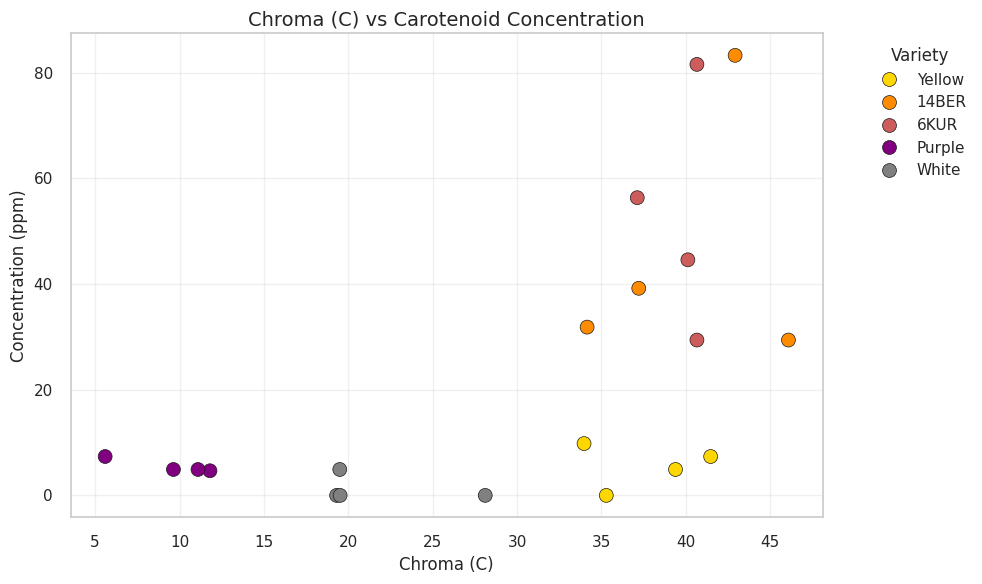

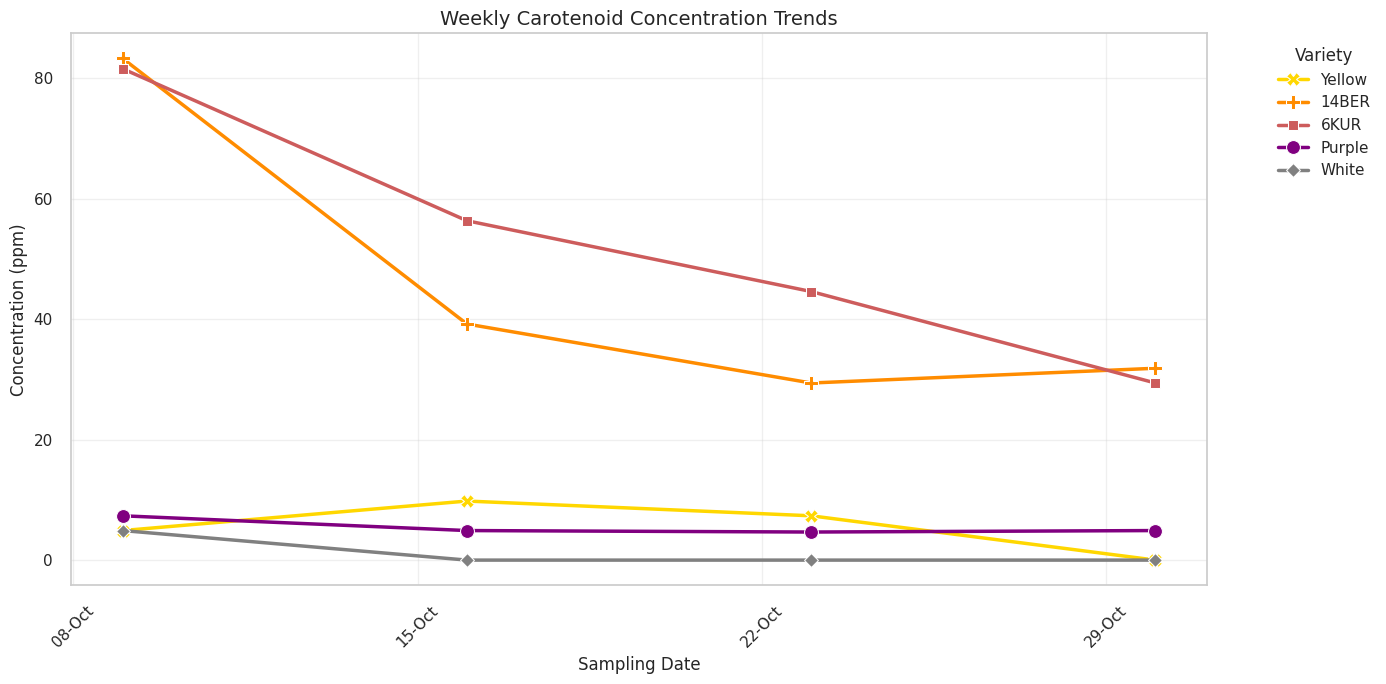

/tmp/ipython-input-1041686296.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


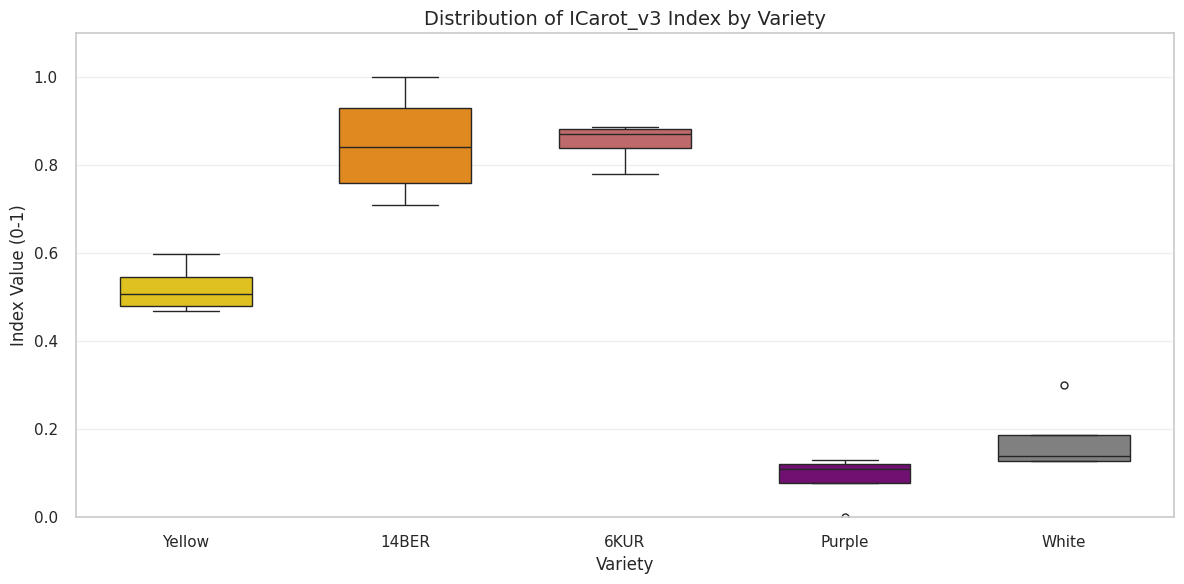

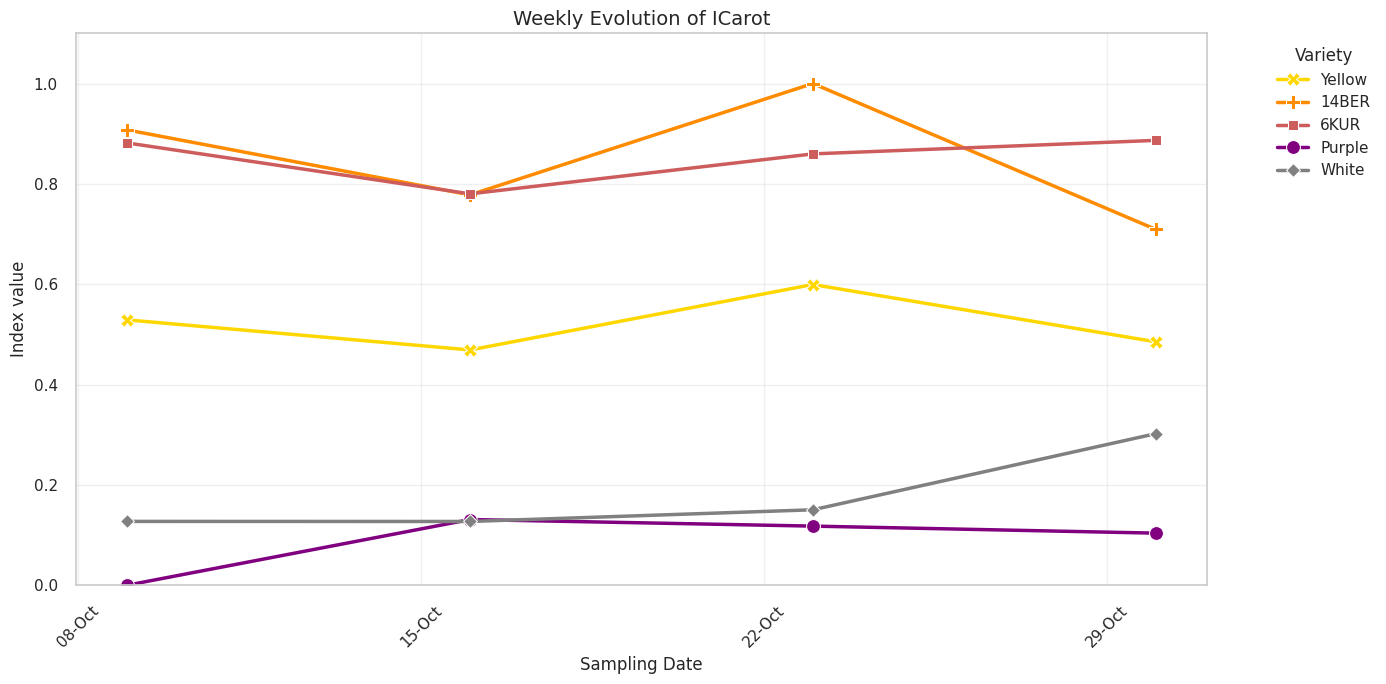

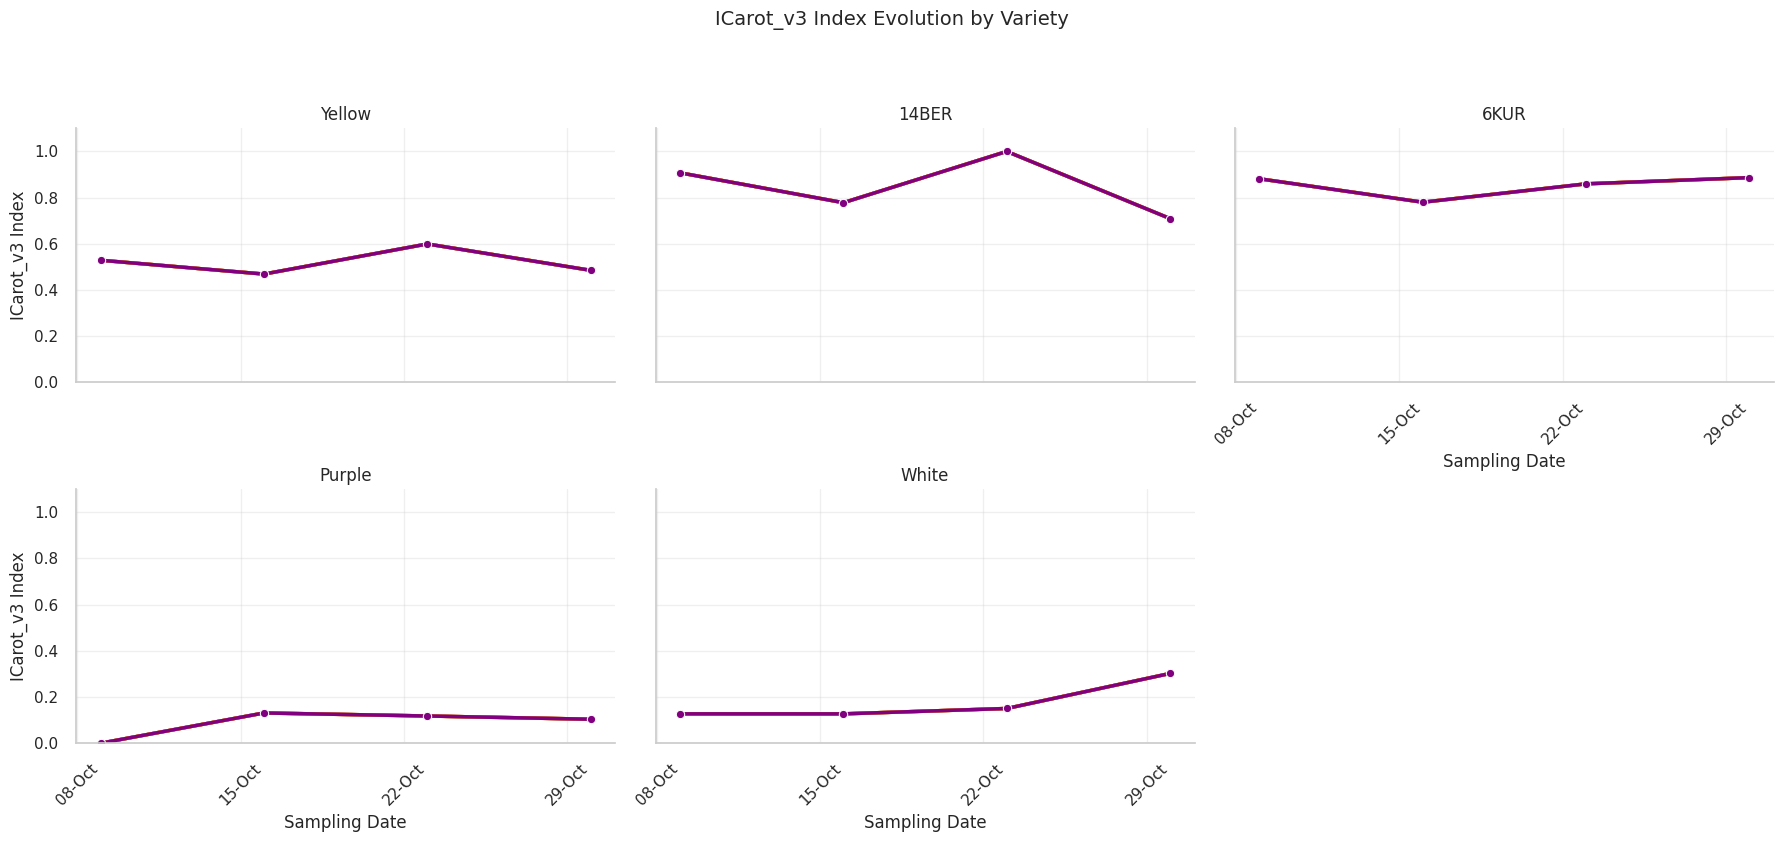

In [ ]:
# === Custom Color Palette ===
custom_palette = {
    'Yellow': '#FFD700',    # Dark yellow (gold)
    'White': '#808080',     # Gray
    '6KUR': '#CD5C5C',      # Muted red (IndianRed)
    '14BER': '#FF8C00',     # Muted orange (DarkOrange)
    'Purple': '#800080'     # Purple
}

# Update the variety order to match your preference
variety_order = ['Yellow', '14BER', '6KUR', 'Purple', 'White']

# === 14. Chroma vs Carotenoid Concentration (SCATTERPLOT) ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged_data,
    x='C',
    y='ppmRefri',
    hue='Variety',
    hue_order=variety_order,
    palette=custom_palette,
    s=100,
    edgecolor='k',
    linewidth=0.5
)
plt.title('Chroma (C) vs Carotenoid Concentration', fontsize=14)
plt.xlabel('Chroma (C)', fontsize=12)
plt.ylabel('Concentration (ppm)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# === 15. Weekly Evolution of Carotenoids (LINEPLOT) ===
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=merged_data,
    x='Dia_muestreo',
    y='ppmRefri',
    hue='Variety',
    hue_order=variety_order,
    style='Variety',
    markers=True,
    markersize=10,
    dashes=False,
    palette=custom_palette,
    linewidth=2.5
)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.title('Weekly Carotenoid Concentration Trends', fontsize=14)
plt.xlabel('Sampling Date', fontsize=12)
plt.ylabel('Concentration (ppm)', fontsize=12)
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === 18. ICarot_v3 Index Distribution (BOXPLOT) ===
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=merged_data,
    x='Variety',
    y='ICarot_v3',
    order=variety_order,
    palette=custom_palette,
    width=0.6,
    fliersize=5,
    linewidth=1
)
plt.title('Distribution of ICarot_v3 Index by Variety', fontsize=14)
plt.xlabel('Variety', fontsize=12)
plt.ylabel('Index Value (0-1)', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# === 19. Time Evolution of ICarot_v3 Index (LINEPLOT) ===
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=merged_data,
    x='Dia_muestreo',
    y='ICarot_v3',
    hue='Variety',
    hue_order=variety_order,
    style='Variety',
    markers=True,
    markersize=10,
    dashes=False,
    palette=custom_palette,
    linewidth=2.5
)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=45)
plt.title('Weekly Evolution of ICarot', fontsize=14)
plt.xlabel('Sampling Date', fontsize=12)
plt.ylabel('Index value', fontsize=12)
plt.legend(title='Variety', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()

# === 20. Faceted Time Series (FACETGRID) ===
g = sns.FacetGrid(
    data=merged_data,
    col='Variety',
    col_order=variety_order,
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=True
)

# Map each variety to its custom color
for variety, color in custom_palette.items():
    subset = merged_data[merged_data['Variety'] == variety]
    g.map_dataframe(
        sns.lineplot,
        x='Dia_muestreo',
        y='ICarot_v3',
        color=color,
        marker='o',
        linewidth=2.5
    )

# Formatting
for ax, variety in zip(g.axes.flat, variety_order):
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1.1)
    ax.set_title(variety)

g.set_axis_labels('Sampling Date', 'ICarot_v3 Index')
g.fig.suptitle('ICarot_v3 Index Evolution by Variety', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0  # Transfer Learning

In [ ]:
# Cargar datos de laboratorio (concentraciones de carotenoides)
carotenoid_data = pd.read_excel('/content/drive/MyDrive/TESIS_ZANAHORIA/Espectral/Semana1_concentraciones.xlsx')
color_data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Espectral/COLOR.xlsx')

# Limpieza y preparación de datos (ajustar según estructura real)
carotenoid_data = carotenoid_data.dropna()  # Eliminar filas con valores faltantes

In [ ]:
pip install tensorflow.keras.applications.efficientnet

ERROR: Could not find a version that satisfies the requirement tensorflow.keras.applications.efficientnet (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.applications.efficientnet


In [ ]:
!pip install -q tensorflow==2.15 keras==2.15

import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, efficientnet
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ---------------------------
# 1. Cargar datos tabulares
# ---------------------------
df_conc = pd.read_excel('/content/drive/MyDrive/TESIS_ZANAHORIA/Espectral/Semana1_concentraciones.xlsx')
df_color = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Espectral/COLOR.xlsx')

df_conc['ID'] = df_conc['Material'].astype(str) + "_" + df_conc['Replica/Repeticion'].astype(str)
df_color['ID'] = df_color['Material'].astype(str) + "_" + df_color['Replica/Repeticion'].astype(str)

df_tab = pd.merge(df_conc, df_color, on='ID', suffixes=('_conc', '_color'))

# ---------------------------
# 2. Recorrer imágenes
# ---------------------------
imagenes_info = []

for ruta_imagen in glob.glob('/content/drive/MyDrive/TESIS_ZANAHORIA/F_ZANA/**/*.*', recursive=True):
    if ruta_imagen.lower().endswith(('.jpg', '.png', '.jpeg')):
        partes = ruta_imagen.split(os.sep)
        fecha = partes[-4]  # Ajustar según estructura real
        tratamiento = partes[-3]
        variedad = partes[-2]
        archivo = partes[-1]

        # Esto depende de cómo se codifica en tus nombres
        material = variedad
        replica = archivo.split('_')[0]

        imagenes_info.append({
            'fecha': fecha,
            'tratamiento': tratamiento,
            'variedad': variedad,
            'Material': material,
            'Replica/Repeticion': replica,
            'ruta': ruta_imagen
        })

df_imgs = pd.DataFrame(imagenes_info)
df_imgs['ID'] = df_imgs['Material'].astype(str) + "_" + df_imgs['Replica/Repeticion'].astype(str)

# ---------------------------
# 3. Unir imágenes y datos
# ---------------------------
df_final = pd.merge(df_tab, df_imgs, on='ID')

# ---------------------------
# 4. Extracción de features con EfficientNetB0
# ---------------------------
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
preprocess_input = efficientnet.preprocess_input

def extraer_features(img_path):
    img = load_img(img_path, target_size=(224,224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array, verbose=0)
    return features.flatten()

df_final['features'] = df_final['ruta'].apply(extraer_features)

# ---------------------------
# 5. Modelo de regresión
# ---------------------------
X = np.stack(df_final['features'].values)
y = df_final['Carotenoides'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = RandomForestRegressor(n_estimators=200, random_state=42)
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))


ModuleNotFoundError: No module named 'tensorflow.keras.preprocessing'